##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 4538368/13568290 [=========>....................] - ETA: 0s

 8396800/13568290 [=================>............] - ETA: 0s

13574144/13568290 [==============================] - 0s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [4]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

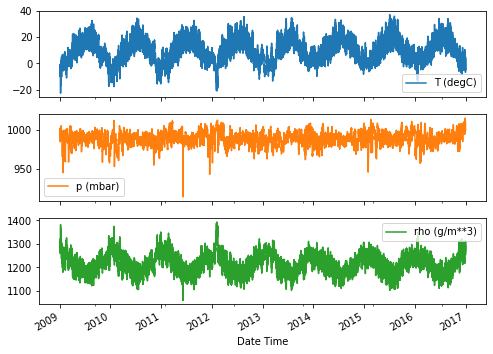

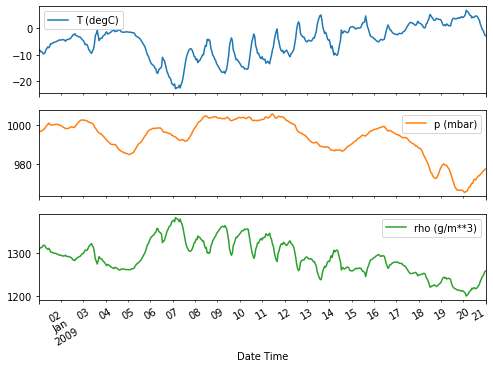

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

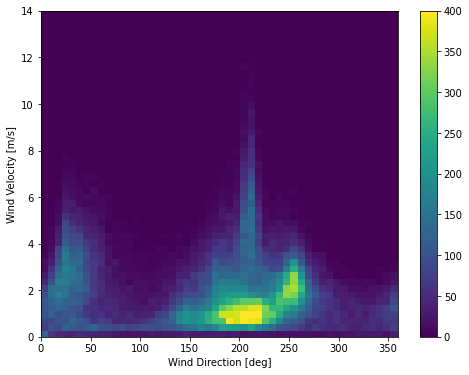

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

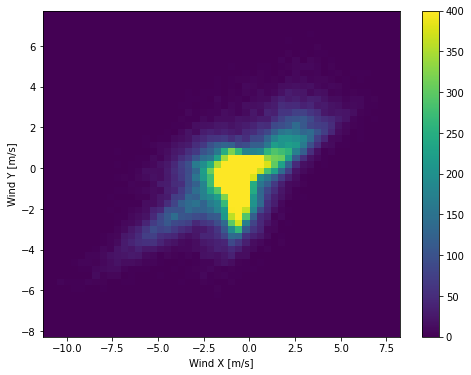

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [12]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

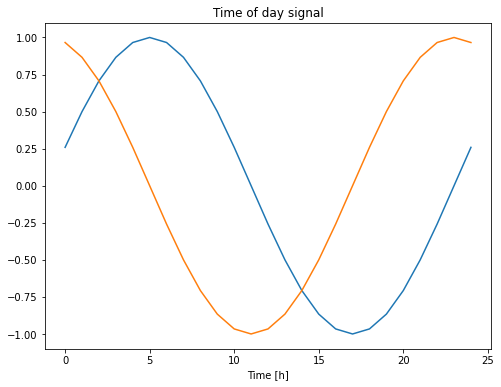

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

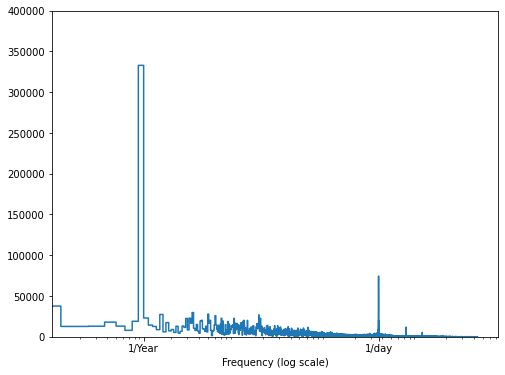

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

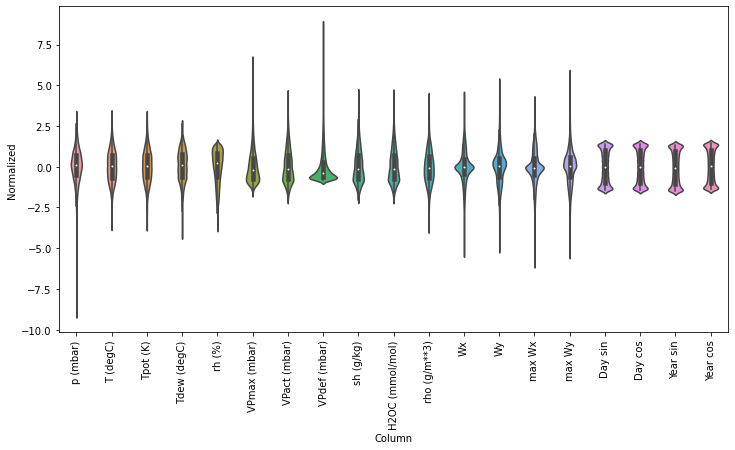

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](images/raw_window_24h.png)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [23]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

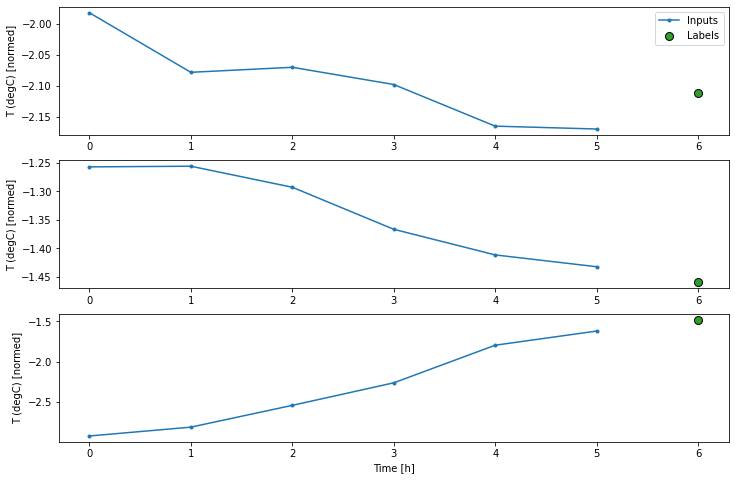

In [26]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

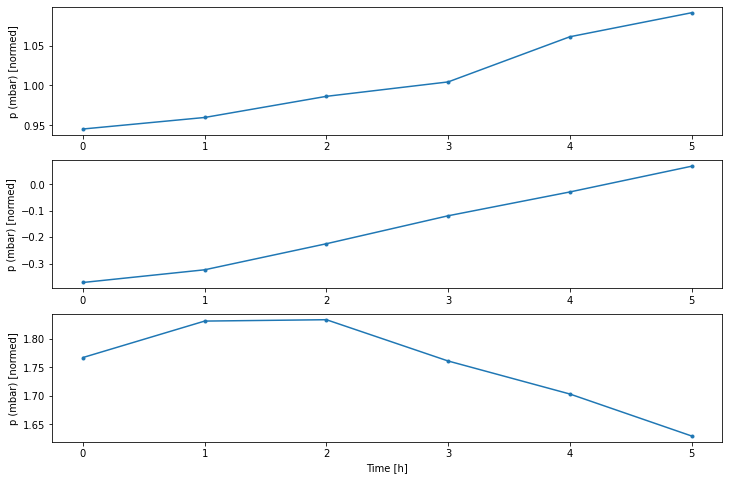

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `T (degC)` value 1h into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 1:08 - loss: 0.0079 - mean_absolute_error: 0.0670

 27/439 [>.............................] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0799  

 52/439 [==>...........................] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0807

 77/439 [====>.........................] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0805

103/439 [======>.......................] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0802

131/439 [=======>......................] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0799

159/439 [=========>....................] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0798

187/439 [===========>..................] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0797

215/439 [=============>................] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0796

242/439 [===============>..............] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0795

269/439 [=================>............] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0794

296/439 [===================>..........] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0794

324/439 [=====================>........] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0793

352/439 [=======================>......] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0792

380/439 [========================>.....] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0792

408/439 [==========================>...] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0791

434/439 [============================>.] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0791

439/439 [==============================] - 1s 2ms/step - loss: 0.0131 - mean_absolute_error: 0.0791


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

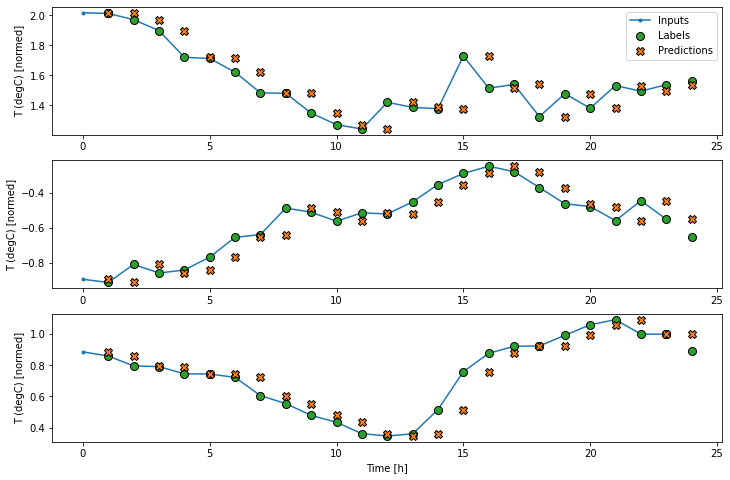

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explanation:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 7:19 - loss: 1.4795 - mean_absolute_error: 0.9574

  22/1534 [..............................] - ETA: 3s - loss: 1.6792 - mean_absolute_error: 1.0426  

  44/1534 [..............................] - ETA: 3s - loss: 1.6611 - mean_absolute_error: 1.0335

  65/1534 [>.............................] - ETA: 3s - loss: 1.6115 - mean_absolute_error: 1.0137

  86/1534 [>.............................] - ETA: 3s - loss: 1.5487 - mean_absolute_error: 0.9894

 108/1534 [=>............................] - ETA: 3s - loss: 1.4787 - mean_absolute_error: 0.9624

 130/1534 [=>............................] - ETA: 3s - loss: 1.4113 - mean_absolute_error: 0.9358

 152/1534 [=>............................] - ETA: 3s - loss: 1.3487 - mean_absolute_error: 0.9106

 174/1534 [==>...........................] - ETA: 3s - loss: 1.2919 - mean_absolute_error: 0.8871

 196/1534 [==>...........................] - ETA: 3s - loss: 1.2402 - mean_absolute_error: 0.8653

 217/1534 [===>..........................] - ETA: 3s - loss: 1.1949 - mean_absolute_error: 0.8458

 239/1534 [===>..........................] - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.8268

 260/1534 [====>.........................] - ETA: 3s - loss: 1.1137 - mean_absolute_error: 0.8099

 281/1534 [====>.........................] - ETA: 2s - loss: 1.0785 - mean_absolute_error: 0.7939

 302/1534 [====>.........................] - ETA: 2s - loss: 1.0459 - mean_absolute_error: 0.7789

 324/1534 [=====>........................] - ETA: 2s - loss: 1.0142 - mean_absolute_error: 0.7640

 345/1534 [=====>........................] - ETA: 2s - loss: 0.9860 - mean_absolute_error: 0.7506

 365/1534 [======>.......................] - ETA: 2s - loss: 0.9608 - mean_absolute_error: 0.7384

 387/1534 [======>.......................] - ETA: 2s - loss: 0.9349 - mean_absolute_error: 0.7257

 409/1534 [======>.......................] - ETA: 2s - loss: 0.9106 - mean_absolute_error: 0.7136

 430/1534 [=======>......................] - ETA: 2s - loss: 0.8887 - mean_absolute_error: 0.7026

 450/1534 [=======>......................] - ETA: 2s - loss: 0.8691 - mean_absolute_error: 0.6926

 470/1534 [========>.....................] - ETA: 2s - loss: 0.8504 - mean_absolute_error: 0.6830

 487/1534 [========>.....................] - ETA: 2s - loss: 0.8353 - mean_absolute_error: 0.6751

 507/1534 [========>.....................] - ETA: 2s - loss: 0.8184 - mean_absolute_error: 0.6662

 527/1534 [=========>....................] - ETA: 2s - loss: 0.8022 - mean_absolute_error: 0.6577

 547/1534 [=========>....................] - ETA: 2s - loss: 0.7868 - mean_absolute_error: 0.6495

 566/1534 [==========>...................] - ETA: 2s - loss: 0.7728 - mean_absolute_error: 0.6419

 586/1534 [==========>...................] - ETA: 2s - loss: 0.7587 - mean_absolute_error: 0.6343

 606/1534 [==========>...................] - ETA: 2s - loss: 0.7452 - mean_absolute_error: 0.6269

 625/1534 [===========>..................] - ETA: 2s - loss: 0.7329 - mean_absolute_error: 0.6201

 645/1534 [===========>..................] - ETA: 2s - loss: 0.7205 - mean_absolute_error: 0.6131

 665/1534 [============>.................] - ETA: 2s - loss: 0.7085 - mean_absolute_error: 0.6064

 686/1534 [============>.................] - ETA: 2s - loss: 0.6965 - mean_absolute_error: 0.5996

 706/1534 [============>.................] - ETA: 2s - loss: 0.6855 - mean_absolute_error: 0.5933

 727/1534 [=============>................] - ETA: 1s - loss: 0.6743 - mean_absolute_error: 0.5869

 747/1534 [=============>................] - ETA: 1s - loss: 0.6641 - mean_absolute_error: 0.5810

 767/1534 [==============>...............] - ETA: 1s - loss: 0.6543 - mean_absolute_error: 0.5752

 788/1534 [==============>...............] - ETA: 1s - loss: 0.6443 - mean_absolute_error: 0.5694

 809/1534 [==============>...............] - ETA: 1s - loss: 0.6347 - mean_absolute_error: 0.5637

 830/1534 [===============>..............] - ETA: 1s - loss: 0.6254 - mean_absolute_error: 0.5581

 851/1534 [===============>..............] - ETA: 1s - loss: 0.6164 - mean_absolute_error: 0.5528

 871/1534 [================>.............] - ETA: 1s - loss: 0.6081 - mean_absolute_error: 0.5478

 892/1534 [================>.............] - ETA: 1s - loss: 0.5997 - mean_absolute_error: 0.5427

 912/1534 [================>.............] - ETA: 1s - loss: 0.5920 - mean_absolute_error: 0.5379

 933/1534 [=================>............] - ETA: 1s - loss: 0.5841 - mean_absolute_error: 0.5331

 953/1534 [=================>............] - ETA: 1s - loss: 0.5768 - mean_absolute_error: 0.5286

 974/1534 [==================>...........] - ETA: 1s - loss: 0.5694 - mean_absolute_error: 0.5240

 992/1534 [==================>...........] - ETA: 1s - loss: 0.5632 - mean_absolute_error: 0.5201

1013/1534 [==================>...........] - ETA: 1s - loss: 0.5562 - mean_absolute_error: 0.5157

1033/1534 [===================>..........] - ETA: 1s - loss: 0.5497 - mean_absolute_error: 0.5116

1054/1534 [===================>..........] - ETA: 1s - loss: 0.5430 - mean_absolute_error: 0.5074

1075/1534 [====================>.........] - ETA: 1s - loss: 0.5366 - mean_absolute_error: 0.5033

1096/1534 [====================>.........] - ETA: 1s - loss: 0.5303 - mean_absolute_error: 0.4992

1116/1534 [====================>.........] - ETA: 1s - loss: 0.5245 - mean_absolute_error: 0.4955

1137/1534 [=====================>........] - ETA: 0s - loss: 0.5185 - mean_absolute_error: 0.4916

1157/1534 [=====================>........] - ETA: 0s - loss: 0.5130 - mean_absolute_error: 0.4880

1178/1534 [======================>.......] - ETA: 0s - loss: 0.5074 - mean_absolute_error: 0.4843

1199/1534 [======================>.......] - ETA: 0s - loss: 0.5019 - mean_absolute_error: 0.4807

1220/1534 [======================>.......] - ETA: 0s - loss: 0.4965 - mean_absolute_error: 0.4772

1241/1534 [=======================>......] - ETA: 0s - loss: 0.4913 - mean_absolute_error: 0.4737

1261/1534 [=======================>......] - ETA: 0s - loss: 0.4864 - mean_absolute_error: 0.4705

1282/1534 [========================>.....] - ETA: 0s - loss: 0.4814 - mean_absolute_error: 0.4671

1302/1534 [========================>.....] - ETA: 0s - loss: 0.4767 - mean_absolute_error: 0.4640

1322/1534 [========================>.....] - ETA: 0s - loss: 0.4722 - mean_absolute_error: 0.4609

1343/1534 [=========================>....] - ETA: 0s - loss: 0.4675 - mean_absolute_error: 0.4578

1363/1534 [=========================>....] - ETA: 0s - loss: 0.4632 - mean_absolute_error: 0.4548

1384/1534 [==========================>...] - ETA: 0s - loss: 0.4587 - mean_absolute_error: 0.4518

1405/1534 [==========================>...] - ETA: 0s - loss: 0.4544 - mean_absolute_error: 0.4488

1425/1534 [==========================>...] - ETA: 0s - loss: 0.4503 - mean_absolute_error: 0.4460

1445/1534 [===========================>..] - ETA: 0s - loss: 0.4463 - mean_absolute_error: 0.4432

1466/1534 [===========================>..] - ETA: 0s - loss: 0.4422 - mean_absolute_error: 0.4404

1486/1534 [============================>.] - ETA: 0s - loss: 0.4384 - mean_absolute_error: 0.4378

1507/1534 [============================>.] - ETA: 0s - loss: 0.4345 - mean_absolute_error: 0.4350

1526/1534 [============================>.] - ETA: 0s - loss: 0.4310 - mean_absolute_error: 0.4326

1534/1534 [==============================] - 5s 3ms/step - loss: 0.4294 - mean_absolute_error: 0.4314 - val_loss: 0.0140 - val_mean_absolute_error: 0.0897


Epoch 2/20
   1/1534 [..............................] - ETA: 25s - loss: 0.0126 - mean_absolute_error: 0.0913

  23/1534 [..............................] - ETA: 3s - loss: 0.0138 - mean_absolute_error: 0.0904 

  45/1534 [..............................] - ETA: 3s - loss: 0.0147 - mean_absolute_error: 0.0916

  67/1534 [>.............................] - ETA: 3s - loss: 0.0150 - mean_absolute_error: 0.0922

  89/1534 [>.............................] - ETA: 3s - loss: 0.0150 - mean_absolute_error: 0.0921

 111/1534 [=>............................] - ETA: 3s - loss: 0.0150 - mean_absolute_error: 0.0919

 132/1534 [=>............................] - ETA: 3s - loss: 0.0149 - mean_absolute_error: 0.0917

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0148 - mean_absolute_error: 0.0915

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0148 - mean_absolute_error: 0.0912

 198/1534 [==>...........................] - ETA: 3s - loss: 0.0147 - mean_absolute_error: 0.0910

 220/1534 [===>..........................] - ETA: 3s - loss: 0.0147 - mean_absolute_error: 0.0908

 242/1534 [===>..........................] - ETA: 3s - loss: 0.0146 - mean_absolute_error: 0.0906

 264/1534 [====>.........................] - ETA: 2s - loss: 0.0146 - mean_absolute_error: 0.0903

 284/1534 [====>.........................] - ETA: 2s - loss: 0.0145 - mean_absolute_error: 0.0901

 306/1534 [====>.........................] - ETA: 2s - loss: 0.0144 - mean_absolute_error: 0.0899

 328/1534 [=====>........................] - ETA: 2s - loss: 0.0144 - mean_absolute_error: 0.0897

 350/1534 [=====>........................] - ETA: 2s - loss: 0.0143 - mean_absolute_error: 0.0895

 372/1534 [======>.......................] - ETA: 2s - loss: 0.0143 - mean_absolute_error: 0.0894

 394/1534 [======>.......................] - ETA: 2s - loss: 0.0142 - mean_absolute_error: 0.0892

 416/1534 [=======>......................] - ETA: 2s - loss: 0.0142 - mean_absolute_error: 0.0890

 438/1534 [=======>......................] - ETA: 2s - loss: 0.0141 - mean_absolute_error: 0.0888

 460/1534 [=======>......................] - ETA: 2s - loss: 0.0141 - mean_absolute_error: 0.0886

 483/1534 [========>.....................] - ETA: 2s - loss: 0.0140 - mean_absolute_error: 0.0885

 505/1534 [========>.....................] - ETA: 2s - loss: 0.0140 - mean_absolute_error: 0.0883

 527/1534 [=========>....................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0881

 549/1534 [=========>....................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0880

 571/1534 [==========>...................] - ETA: 2s - loss: 0.0138 - mean_absolute_error: 0.0878

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0138 - mean_absolute_error: 0.0877

 615/1534 [===========>..................] - ETA: 2s - loss: 0.0137 - mean_absolute_error: 0.0875

 637/1534 [===========>..................] - ETA: 2s - loss: 0.0137 - mean_absolute_error: 0.0874

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0136 - mean_absolute_error: 0.0873

 682/1534 [============>.................] - ETA: 1s - loss: 0.0136 - mean_absolute_error: 0.0871

 703/1534 [============>.................] - ETA: 1s - loss: 0.0136 - mean_absolute_error: 0.0870

 725/1534 [=============>................] - ETA: 1s - loss: 0.0135 - mean_absolute_error: 0.0869

 746/1534 [=============>................] - ETA: 1s - loss: 0.0135 - mean_absolute_error: 0.0868

 768/1534 [==============>...............] - ETA: 1s - loss: 0.0135 - mean_absolute_error: 0.0866

 790/1534 [==============>...............] - ETA: 1s - loss: 0.0134 - mean_absolute_error: 0.0865

 812/1534 [==============>...............] - ETA: 1s - loss: 0.0134 - mean_absolute_error: 0.0864

 834/1534 [===============>..............] - ETA: 1s - loss: 0.0133 - mean_absolute_error: 0.0863

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0133 - mean_absolute_error: 0.0862

 877/1534 [================>.............] - ETA: 1s - loss: 0.0133 - mean_absolute_error: 0.0861

 899/1534 [================>.............] - ETA: 1s - loss: 0.0132 - mean_absolute_error: 0.0860

 921/1534 [=================>............] - ETA: 1s - loss: 0.0132 - mean_absolute_error: 0.0859

 942/1534 [=================>............] - ETA: 1s - loss: 0.0132 - mean_absolute_error: 0.0858

 964/1534 [=================>............] - ETA: 1s - loss: 0.0132 - mean_absolute_error: 0.0857

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0131 - mean_absolute_error: 0.0856

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0131 - mean_absolute_error: 0.0855

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0131 - mean_absolute_error: 0.0854

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0131 - mean_absolute_error: 0.0853

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0130 - mean_absolute_error: 0.0852

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0130 - mean_absolute_error: 0.0851

1120/1534 [====================>.........] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0850

1142/1534 [=====================>........] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0850

1164/1534 [=====================>........] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0849

1185/1534 [======================>.......] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0848

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0847

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0846

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0846

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0845

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0844

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0843

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0843

1361/1534 [=========================>....] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0842

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0841

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0841

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0840

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0839

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0839

1492/1534 [============================>.] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0838

1513/1534 [============================>.] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0838

1533/1534 [============================>.] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0837

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0837 - val_loss: 0.0102 - val_mean_absolute_error: 0.0760


Epoch 3/20
   1/1534 [..............................] - ETA: 25s - loss: 0.0105 - mean_absolute_error: 0.0784

  23/1534 [..............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0753 

  45/1534 [..............................] - ETA: 3s - loss: 0.0112 - mean_absolute_error: 0.0767

  67/1534 [>.............................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0776

  88/1534 [>.............................] - ETA: 3s - loss: 0.0115 - mean_absolute_error: 0.0780

 110/1534 [=>............................] - ETA: 3s - loss: 0.0115 - mean_absolute_error: 0.0781

 132/1534 [=>............................] - ETA: 3s - loss: 0.0115 - mean_absolute_error: 0.0781

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0781

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0780

 199/1534 [==>...........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0780

 219/1534 [===>..........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0779

 239/1534 [===>..........................] - ETA: 3s - loss: 0.0113 - mean_absolute_error: 0.0779

 260/1534 [====>.........................] - ETA: 3s - loss: 0.0113 - mean_absolute_error: 0.0778

 282/1534 [====>.........................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0778

 304/1534 [====>.........................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0777

 326/1534 [=====>........................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0777

 348/1534 [=====>........................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0776

 370/1534 [======>.......................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0776

 392/1534 [======>.......................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0775

 414/1534 [=======>......................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0775

 436/1534 [=======>......................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0775

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0774

 480/1534 [========>.....................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0774

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0773

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0773

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0772

 563/1534 [==========>...................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0772

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0771

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0771

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0770

 651/1534 [===========>..................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0770

 673/1534 [============>.................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0770

 695/1534 [============>.................] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0770

 716/1534 [=============>................] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0769

 737/1534 [=============>................] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0769

 759/1534 [=============>................] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0769

 781/1534 [==============>...............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0768

 803/1534 [==============>...............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0768

 825/1534 [===============>..............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0768

 847/1534 [===============>..............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0767

 869/1534 [===============>..............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0767

 891/1534 [================>.............] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0767

 913/1534 [================>.............] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0767

 935/1534 [=================>............] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0766

 956/1534 [=================>............] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0766

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0766

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0766

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0765

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0765

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0765

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0765

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0764

1131/1534 [=====================>........] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0764

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0764

1174/1534 [=====================>........] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0764

1196/1534 [======================>.......] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0764

1218/1534 [======================>.......] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0763

1239/1534 [=======================>......] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0763

1262/1534 [=======================>......] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0763

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0763

1302/1534 [========================>.....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0762

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0762

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0762

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0762

1388/1534 [==========================>...] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0762

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0762

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0761

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0761

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0761

1498/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0761

1520/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0761

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0761 - val_loss: 0.0098 - val_mean_absolute_error: 0.0741


Epoch 4/20
   1/1534 [..............................] - ETA: 24s - loss: 0.0109 - mean_absolute_error: 0.0800

  23/1534 [..............................] - ETA: 3s - loss: 0.0115 - mean_absolute_error: 0.0803 

  45/1534 [..............................] - ETA: 3s - loss: 0.0112 - mean_absolute_error: 0.0788

  67/1534 [>.............................] - ETA: 3s - loss: 0.0112 - mean_absolute_error: 0.0787

  89/1534 [>.............................] - ETA: 3s - loss: 0.0112 - mean_absolute_error: 0.0784

 111/1534 [=>............................] - ETA: 3s - loss: 0.0112 - mean_absolute_error: 0.0781

 132/1534 [=>............................] - ETA: 3s - loss: 0.0111 - mean_absolute_error: 0.0778

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0110 - mean_absolute_error: 0.0775

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0110 - mean_absolute_error: 0.0772

 198/1534 [==>...........................] - ETA: 3s - loss: 0.0109 - mean_absolute_error: 0.0771

 220/1534 [===>..........................] - ETA: 3s - loss: 0.0109 - mean_absolute_error: 0.0769

 240/1534 [===>..........................] - ETA: 3s - loss: 0.0109 - mean_absolute_error: 0.0768

 262/1534 [====>.........................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0767

 284/1534 [====>.........................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0765

 306/1534 [====>.........................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0764

 328/1534 [=====>........................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0764

 348/1534 [=====>........................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0763

 369/1534 [======>.......................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0762

 391/1534 [======>.......................] - ETA: 2s - loss: 0.0107 - mean_absolute_error: 0.0762

 413/1534 [=======>......................] - ETA: 2s - loss: 0.0107 - mean_absolute_error: 0.0761

 435/1534 [=======>......................] - ETA: 2s - loss: 0.0107 - mean_absolute_error: 0.0760

 457/1534 [=======>......................] - ETA: 2s - loss: 0.0107 - mean_absolute_error: 0.0760

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0107 - mean_absolute_error: 0.0759

 501/1534 [========>.....................] - ETA: 2s - loss: 0.0106 - mean_absolute_error: 0.0758

 522/1534 [=========>....................] - ETA: 2s - loss: 0.0106 - mean_absolute_error: 0.0758

 544/1534 [=========>....................] - ETA: 2s - loss: 0.0106 - mean_absolute_error: 0.0757

 566/1534 [==========>...................] - ETA: 2s - loss: 0.0106 - mean_absolute_error: 0.0756

 588/1534 [==========>...................] - ETA: 2s - loss: 0.0106 - mean_absolute_error: 0.0756

 610/1534 [==========>...................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0755

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0755

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0755

 676/1534 [============>.................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0754

 699/1534 [============>.................] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0754

 722/1534 [=============>................] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0753

 742/1534 [=============>................] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0753

 764/1534 [=============>................] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0753

 786/1534 [==============>...............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0753

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

 828/1534 [===============>..............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

 850/1534 [===============>..............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

 871/1534 [================>.............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

 893/1534 [================>.............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

 915/1534 [================>.............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

 937/1534 [=================>............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0750

 959/1534 [=================>............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0750

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0750

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0103 - mean_absolute_error: 0.0750

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0103 - mean_absolute_error: 0.0749

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0103 - mean_absolute_error: 0.0749

1069/1534 [===================>..........] - ETA: 1s - loss: 0.0103 - mean_absolute_error: 0.0749

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0103 - mean_absolute_error: 0.0749

1113/1534 [====================>.........] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0748

1136/1534 [=====================>........] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0748

1158/1534 [=====================>........] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0748

1180/1534 [======================>.......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0748

1202/1534 [======================>.......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0748

1224/1534 [======================>.......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0747

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0747

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0747

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0747

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0747

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0746

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0746

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0746

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0746

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0746

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0746

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0745

1484/1534 [============================>.] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0745

1505/1534 [============================>.] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0745

1527/1534 [============================>.] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0745

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0102 - mean_absolute_error: 0.0745 - val_loss: 0.0095 - val_mean_absolute_error: 0.0723


Epoch 5/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0059 - mean_absolute_error: 0.0610

  20/1534 [..............................] - ETA: 4s - loss: 0.0096 - mean_absolute_error: 0.0709 

  39/1534 [..............................] - ETA: 4s - loss: 0.0102 - mean_absolute_error: 0.0725

  59/1534 [>.............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0737

  80/1534 [>.............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0742

 100/1534 [>.............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0743

 121/1534 [=>............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0744

 142/1534 [=>............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0744

 163/1534 [==>...........................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0744

 184/1534 [==>...........................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0744

 205/1534 [===>..........................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0744

 225/1534 [===>..........................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0743

 246/1534 [===>..........................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0744

 266/1534 [====>.........................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0744

 287/1534 [====>.........................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0744

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0743

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0743

 350/1534 [=====>........................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0743

 371/1534 [======>.......................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0743

 393/1534 [======>.......................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0743

 414/1534 [=======>......................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0743

 435/1534 [=======>......................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0743

 456/1534 [=======>......................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0742

 477/1534 [========>.....................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0742

 498/1534 [========>.....................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0742

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0741

 536/1534 [=========>....................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0741

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0741

 578/1534 [==========>...................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0740

 599/1534 [==========>...................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0740

 619/1534 [===========>..................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0740

 640/1534 [===========>..................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0740

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0740

 682/1534 [============>.................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0739

 703/1534 [============>.................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0739

 724/1534 [=============>................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0739

 744/1534 [=============>................] - ETA: 1s - loss: 0.0102 - mean_absolute_error: 0.0739

 765/1534 [=============>................] - ETA: 1s - loss: 0.0102 - mean_absolute_error: 0.0739

 786/1534 [==============>...............] - ETA: 1s - loss: 0.0102 - mean_absolute_error: 0.0739

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0738

 829/1534 [===============>..............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0738

 849/1534 [===============>..............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0738

 870/1534 [================>.............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0738

 891/1534 [================>.............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0738

 912/1534 [================>.............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0737

 932/1534 [=================>............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0737

 953/1534 [=================>............] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0737

 974/1534 [==================>...........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0737

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0737

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0737

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0736

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0736

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0736

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0736

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0736

1141/1534 [=====================>........] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0736

1160/1534 [=====================>........] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0736

1179/1534 [======================>.......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1198/1534 [======================>.......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1218/1534 [======================>.......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1238/1534 [=======================>......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1336/1534 [=========================>....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1497/1534 [============================>.] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1517/1534 [============================>.] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0100 - mean_absolute_error: 0.0734 - val_loss: 0.0094 - val_mean_absolute_error: 0.0726


Epoch 6/20
   1/1534 [..............................] - ETA: 24s - loss: 0.0079 - mean_absolute_error: 0.0726

  22/1534 [..............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0738 

  43/1534 [..............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0737

  64/1534 [>.............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0740

  85/1534 [>.............................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0741

 105/1534 [=>............................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0742

 126/1534 [=>............................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0741

 147/1534 [=>............................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0740

 168/1534 [==>...........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0740

 189/1534 [==>...........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0739

 210/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0739

 230/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0739

 250/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0738

 271/1534 [====>.........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0738

 288/1534 [====>.........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0738

 309/1534 [=====>........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0737

 330/1534 [=====>........................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0737

 350/1534 [=====>........................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0737

 370/1534 [======>.......................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0737

 391/1534 [======>.......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0737

 413/1534 [=======>......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0736

 434/1534 [=======>......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0736

 455/1534 [=======>......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0736

 476/1534 [========>.....................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0736

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0735

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0735

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0734

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0734

 581/1534 [==========>...................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0734

 602/1534 [==========>...................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0734

 622/1534 [===========>..................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0733

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0733

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0733

 684/1534 [============>.................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0733

 705/1534 [============>.................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0733

 726/1534 [=============>................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0733

 746/1534 [=============>................] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 767/1534 [==============>...............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 809/1534 [==============>...............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 830/1534 [===============>..............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 851/1534 [===============>..............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0731

 872/1534 [================>.............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0731

 893/1534 [================>.............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0731

 914/1534 [================>.............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0731

 935/1534 [=================>............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0731

 956/1534 [=================>............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0730

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0730

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0730

1018/1534 [==================>...........] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0730

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0729

1122/1534 [====================>.........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0729

1142/1534 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0729

1162/1534 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0729

1183/1534 [======================>.......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0729

1204/1534 [======================>.......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0729

1225/1534 [======================>.......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0729

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0727

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0727

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0727

1494/1534 [============================>.] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0727

1515/1534 [============================>.] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0727

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0098 - mean_absolute_error: 0.0727 - val_loss: 0.0093 - val_mean_absolute_error: 0.0719


Epoch 7/20
   1/1534 [..............................] - ETA: 24s - loss: 0.0117 - mean_absolute_error: 0.0918

  22/1534 [..............................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0784 

  43/1534 [..............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0768

  65/1534 [>.............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0764

  85/1534 [>.............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0759

 104/1534 [=>............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0757

 123/1534 [=>............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0754

 144/1534 [=>............................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0751

 166/1534 [==>...........................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0749

 188/1534 [==>...........................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0747

 210/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0745

 232/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0744

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0743

 277/1534 [====>.........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0742

 299/1534 [====>.........................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0741

 321/1534 [=====>........................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0740

 343/1534 [=====>........................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0740

 365/1534 [======>.......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0739

 387/1534 [======>.......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0739

 409/1534 [======>.......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0738

 431/1534 [=======>......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0738

 453/1534 [=======>......................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0737

 475/1534 [========>.....................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0736

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0736

 520/1534 [=========>....................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0735

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0735

 565/1534 [==========>...................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0734

 587/1534 [==========>...................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0734

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0733

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0733

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0733

 674/1534 [============>.................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0732

 695/1534 [============>.................] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 714/1534 [============>.................] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 735/1534 [=============>................] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 756/1534 [=============>................] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0731

 776/1534 [==============>...............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0731

 797/1534 [==============>...............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0731

 819/1534 [===============>..............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0731

 841/1534 [===============>..............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

 862/1534 [===============>..............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

 884/1534 [================>.............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

 904/1534 [================>.............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0729

 925/1534 [=================>............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0729

 946/1534 [=================>............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0729

 967/1534 [=================>............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0729

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0728

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0728

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0728

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0728

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0728

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0728

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0727

1132/1534 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0727

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0727

1175/1534 [=====================>........] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1196/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1218/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1262/1534 [=======================>......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1503/1534 [============================>.] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1525/1534 [============================>.] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0724

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0097 - mean_absolute_error: 0.0724 - val_loss: 0.0094 - val_mean_absolute_error: 0.0726


Epoch 8/20
   1/1534 [..............................] - ETA: 24s - loss: 0.0101 - mean_absolute_error: 0.0742

  23/1534 [..............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0761 

  45/1534 [..............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0749

  67/1534 [>.............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0746

  89/1534 [>.............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0744

 111/1534 [=>............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0742

 133/1534 [=>............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0741

 156/1534 [==>...........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0739

 178/1534 [==>...........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0738

 201/1534 [==>...........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0736

 223/1534 [===>..........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0735

 245/1534 [===>..........................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0735

 267/1534 [====>.........................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0734

 289/1534 [====>.........................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0733

 312/1534 [=====>........................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0732

 335/1534 [=====>........................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0732

 357/1534 [=====>........................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0731

 379/1534 [======>.......................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0731

 401/1534 [======>.......................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0731

 424/1534 [=======>......................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0730

 446/1534 [=======>......................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0730

 467/1534 [========>.....................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0729

 487/1534 [========>.....................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0729

 504/1534 [========>.....................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0728

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0728

 544/1534 [=========>....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0727

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0727

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0727

 605/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0726

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0726

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0726

 670/1534 [============>.................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0725

 691/1534 [============>.................] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0725

 712/1534 [============>.................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0725

 734/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0725

 755/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0724

 776/1534 [==============>...............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0724

 797/1534 [==============>...............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0724

 819/1534 [===============>..............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0724

 841/1534 [===============>..............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0723

 862/1534 [===============>..............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0723

 884/1534 [================>.............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0723

 905/1534 [================>.............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0723

 927/1534 [=================>............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 948/1534 [=================>............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 969/1534 [=================>............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0722

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0722

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0722

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1120/1534 [====================>.........] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0721

1142/1534 [=====================>........] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0721

1163/1534 [=====================>........] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1185/1534 [======================>.......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1206/1534 [======================>.......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1228/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1403/1534 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1489/1534 [============================>.] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1512/1534 [============================>.] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0718

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0718 - val_loss: 0.0091 - val_mean_absolute_error: 0.0711


Epoch 9/20
   1/1534 [..............................] - ETA: 23s - loss: 0.0092 - mean_absolute_error: 0.0739

  23/1534 [..............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0736 

  44/1534 [..............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0732

  66/1534 [>.............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0735

  88/1534 [>.............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0735

 109/1534 [=>............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0734

 131/1534 [=>............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0733

 152/1534 [=>............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0732

 173/1534 [==>...........................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0730

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0729

 217/1534 [===>..........................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0729

 239/1534 [===>..........................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0728

 261/1534 [====>.........................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0728

 283/1534 [====>.........................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0727

 306/1534 [====>.........................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0727

 329/1534 [=====>........................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0727

 351/1534 [=====>........................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0726

 373/1534 [======>.......................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0726

 395/1534 [======>.......................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0726

 418/1534 [=======>......................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0725

 440/1534 [=======>......................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0725

 462/1534 [========>.....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0725

 484/1534 [========>.....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0724

 506/1534 [========>.....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0724

 528/1534 [=========>....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0723

 550/1534 [=========>....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0723

 572/1534 [==========>...................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0723

 594/1534 [==========>...................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 616/1534 [===========>..................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 638/1534 [===========>..................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0721

 683/1534 [============>.................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0721

 705/1534 [============>.................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0721

 727/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0721

 749/1534 [=============>................] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

 793/1534 [==============>...............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

 837/1534 [===============>..............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

 859/1534 [===============>..............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0719

 879/1534 [================>.............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0719

 902/1534 [================>.............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0719

 924/1534 [=================>............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0719

 946/1534 [=================>............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0719

 968/1534 [=================>............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0718

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0718

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0718

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0718

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0718

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0718

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0717

1123/1534 [====================>.........] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1145/1534 [=====================>........] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1167/1534 [=====================>........] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1189/1534 [======================>.......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1361/1534 [=========================>....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1428/1534 [==========================>...] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0715

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0715

1496/1534 [============================>.] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0715

1518/1534 [============================>.] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0715

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0715 - val_loss: 0.0090 - val_mean_absolute_error: 0.0704


Epoch 10/20
   1/1534 [..............................] - ETA: 24s - loss: 0.0106 - mean_absolute_error: 0.0870

  23/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0723 

  45/1534 [..............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0721

  67/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0724

  88/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0725

 109/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0725

 131/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0725

 153/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0724

 175/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0723

 197/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0722

 219/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0722

 239/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0722

 261/1534 [====>.........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 283/1534 [====>.........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0721

 305/1534 [====>.........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0721

 326/1534 [=====>........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0721

 348/1534 [=====>........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0721

 370/1534 [======>.......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0721

 393/1534 [======>.......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0720

 415/1534 [=======>......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0720

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0720

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0720

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0719

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0719

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0718

 540/1534 [=========>....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0718

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0718

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0717

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 675/1534 [============>.................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 697/1534 [============>.................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0716

 719/1534 [=============>................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0716

 741/1534 [=============>................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0716

 763/1534 [=============>................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0716

 785/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 829/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 851/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 873/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 895/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 917/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 939/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 961/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1114/1534 [====================>.........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0713

1136/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0713

1158/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0713

1180/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1202/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1224/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1489/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1511/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0094 - mean_absolute_error: 0.0711 - val_loss: 0.0090 - val_mean_absolute_error: 0.0707


Epoch 11/20
   1/1534 [..............................] - ETA: 24s - loss: 0.0073 - mean_absolute_error: 0.0751

  23/1534 [..............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0736 

  46/1534 [..............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0728

  68/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0729

  90/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0728

 112/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0726

 134/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0726

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0725

 179/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0724

 201/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0723

 223/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0722

 245/1534 [===>..........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0722

 267/1534 [====>.........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0721

 289/1534 [====>.........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0721

 311/1534 [=====>........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0720

 333/1534 [=====>........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0720

 355/1534 [=====>........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0720

 377/1534 [======>.......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0720

 399/1534 [======>.......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0719

 421/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0719

 443/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0719

 465/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0718

 488/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0718

 510/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0718

 532/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 554/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 598/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 620/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 686/1534 [============>.................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 709/1534 [============>.................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 731/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 753/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 776/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 798/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 820/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 842/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

 863/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

 884/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

 904/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

 925/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

 948/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0712

 970/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0712

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0712

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0712

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0712

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0712

1082/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0711

1104/1534 [====================>.........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1126/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1149/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0711

1171/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0711

1193/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0711

1215/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0711

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0711

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1368/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1435/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1502/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1524/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0709 - val_loss: 0.0090 - val_mean_absolute_error: 0.0705


  1/439 [..............................] - ETA: 19s - loss: 0.0065 - mean_absolute_error: 0.0634

 26/439 [>.............................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0684 

 51/439 [==>...........................] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0666

 76/439 [====>.........................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0688

101/439 [=====>........................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0697

126/439 [=======>......................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0700

152/439 [=========>....................] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0703

177/439 [===========>..................] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0711

201/439 [============>.................] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0709

226/439 [==============>...............] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0707

251/439 [================>.............] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0708

276/439 [=================>............] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0709

301/439 [===================>..........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0709

325/439 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0707

349/439 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0705

373/439 [========================>.....] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0704

398/439 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0706

423/439 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0706

439/439 [==============================] - 1s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0705


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

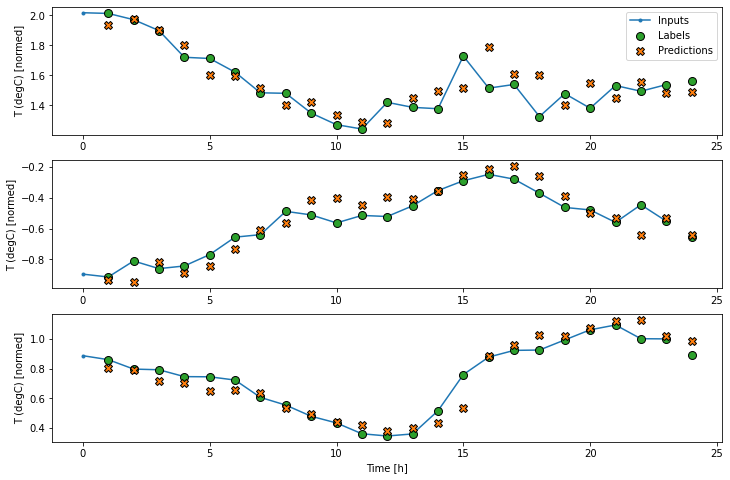

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

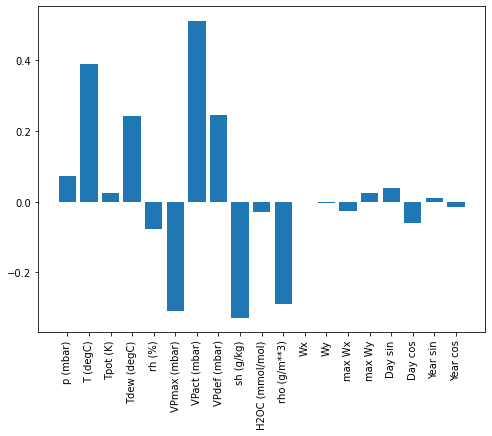

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 10:06 - loss: 1.3652 - mean_absolute_error: 0.9585

  18/1534 [..............................] - ETA: 4s - loss: 0.8954 - mean_absolute_error: 0.7289   

  36/1534 [..............................] - ETA: 4s - loss: 0.6298 - mean_absolute_error: 0.5723

  53/1534 [>.............................] - ETA: 4s - loss: 0.5050 - mean_absolute_error: 0.4923

  71/1534 [>.............................] - ETA: 4s - loss: 0.4233 - mean_absolute_error: 0.4369

  89/1534 [>.............................] - ETA: 4s - loss: 0.3676 - mean_absolute_error: 0.3972

 106/1534 [=>............................] - ETA: 4s - loss: 0.3288 - mean_absolute_error: 0.3686

 124/1534 [=>............................] - ETA: 4s - loss: 0.2969 - mean_absolute_error: 0.3445

 142/1534 [=>............................] - ETA: 4s - loss: 0.2716 - mean_absolute_error: 0.3249

 159/1534 [==>...........................] - ETA: 4s - loss: 0.2520 - mean_absolute_error: 0.3094

 177/1534 [==>...........................] - ETA: 3s - loss: 0.2346 - mean_absolute_error: 0.2953

 194/1534 [==>...........................] - ETA: 3s - loss: 0.2206 - mean_absolute_error: 0.2839

 212/1534 [===>..........................] - ETA: 3s - loss: 0.2077 - mean_absolute_error: 0.2732

 230/1534 [===>..........................] - ETA: 3s - loss: 0.1965 - mean_absolute_error: 0.2637

 247/1534 [===>..........................] - ETA: 3s - loss: 0.1872 - mean_absolute_error: 0.2557

 265/1534 [====>.........................] - ETA: 3s - loss: 0.1784 - mean_absolute_error: 0.2480

 282/1534 [====>.........................] - ETA: 3s - loss: 0.1709 - mean_absolute_error: 0.2414

 299/1534 [====>.........................] - ETA: 3s - loss: 0.1642 - mean_absolute_error: 0.2354

 316/1534 [=====>........................] - ETA: 3s - loss: 0.1580 - mean_absolute_error: 0.2298

 334/1534 [=====>........................] - ETA: 3s - loss: 0.1521 - mean_absolute_error: 0.2244

 351/1534 [=====>........................] - ETA: 3s - loss: 0.1470 - mean_absolute_error: 0.2197

 368/1534 [======>.......................] - ETA: 3s - loss: 0.1422 - mean_absolute_error: 0.2153

 385/1534 [======>.......................] - ETA: 3s - loss: 0.1378 - mean_absolute_error: 0.2112

 402/1534 [======>.......................] - ETA: 3s - loss: 0.1337 - mean_absolute_error: 0.2074

 419/1534 [=======>......................] - ETA: 3s - loss: 0.1299 - mean_absolute_error: 0.2038

 436/1534 [=======>......................] - ETA: 3s - loss: 0.1264 - mean_absolute_error: 0.2004

 453/1534 [=======>......................] - ETA: 3s - loss: 0.1231 - mean_absolute_error: 0.1972

 470/1534 [========>.....................] - ETA: 3s - loss: 0.1200 - mean_absolute_error: 0.1942

 487/1534 [========>.....................] - ETA: 3s - loss: 0.1170 - mean_absolute_error: 0.1914

 505/1534 [========>.....................] - ETA: 3s - loss: 0.1141 - mean_absolute_error: 0.1885

 521/1534 [=========>....................] - ETA: 2s - loss: 0.1116 - mean_absolute_error: 0.1861

 537/1534 [=========>....................] - ETA: 2s - loss: 0.1093 - mean_absolute_error: 0.1838

 555/1534 [=========>....................] - ETA: 2s - loss: 0.1068 - mean_absolute_error: 0.1814

 572/1534 [==========>...................] - ETA: 2s - loss: 0.1046 - mean_absolute_error: 0.1791

 590/1534 [==========>...................] - ETA: 2s - loss: 0.1024 - mean_absolute_error: 0.1769

 607/1534 [==========>...................] - ETA: 2s - loss: 0.1003 - mean_absolute_error: 0.1749

 624/1534 [===========>..................] - ETA: 2s - loss: 0.0984 - mean_absolute_error: 0.1729

 641/1534 [===========>..................] - ETA: 2s - loss: 0.0966 - mean_absolute_error: 0.1711

 659/1534 [===========>..................] - ETA: 2s - loss: 0.0947 - mean_absolute_error: 0.1692

 676/1534 [============>.................] - ETA: 2s - loss: 0.0931 - mean_absolute_error: 0.1675

 693/1534 [============>.................] - ETA: 2s - loss: 0.0915 - mean_absolute_error: 0.1658

 710/1534 [============>.................] - ETA: 2s - loss: 0.0899 - mean_absolute_error: 0.1642

 728/1534 [=============>................] - ETA: 2s - loss: 0.0884 - mean_absolute_error: 0.1626

 745/1534 [=============>................] - ETA: 2s - loss: 0.0870 - mean_absolute_error: 0.1612

 763/1534 [=============>................] - ETA: 2s - loss: 0.0855 - mean_absolute_error: 0.1597

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0842 - mean_absolute_error: 0.1583

 797/1534 [==============>...............] - ETA: 2s - loss: 0.0830 - mean_absolute_error: 0.1570

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0818 - mean_absolute_error: 0.1557

 832/1534 [===============>..............] - ETA: 2s - loss: 0.0805 - mean_absolute_error: 0.1544

 850/1534 [===============>..............] - ETA: 2s - loss: 0.0794 - mean_absolute_error: 0.1531

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0783 - mean_absolute_error: 0.1520

 884/1534 [================>.............] - ETA: 1s - loss: 0.0772 - mean_absolute_error: 0.1509

 901/1534 [================>.............] - ETA: 1s - loss: 0.0762 - mean_absolute_error: 0.1498

 918/1534 [================>.............] - ETA: 1s - loss: 0.0752 - mean_absolute_error: 0.1487

 935/1534 [=================>............] - ETA: 1s - loss: 0.0743 - mean_absolute_error: 0.1477

 952/1534 [=================>............] - ETA: 1s - loss: 0.0734 - mean_absolute_error: 0.1467

 970/1534 [=================>............] - ETA: 1s - loss: 0.0724 - mean_absolute_error: 0.1457

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0715 - mean_absolute_error: 0.1447

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0706 - mean_absolute_error: 0.1437

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0697 - mean_absolute_error: 0.1428

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0689 - mean_absolute_error: 0.1419

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0681 - mean_absolute_error: 0.1410

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0674 - mean_absolute_error: 0.1402

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0667 - mean_absolute_error: 0.1395

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0660 - mean_absolute_error: 0.1387

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0653 - mean_absolute_error: 0.1379

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0647 - mean_absolute_error: 0.1372

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0641 - mean_absolute_error: 0.1365

1175/1534 [=====================>........] - ETA: 1s - loss: 0.0634 - mean_absolute_error: 0.1358

1192/1534 [======================>.......] - ETA: 1s - loss: 0.0628 - mean_absolute_error: 0.1351

1210/1534 [======================>.......] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1344

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1338

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1331

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0604 - mean_absolute_error: 0.1325

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0599 - mean_absolute_error: 0.1319

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0594 - mean_absolute_error: 0.1312

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.1306

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0583 - mean_absolute_error: 0.1300

1348/1534 [=========================>....] - ETA: 0s - loss: 0.0578 - mean_absolute_error: 0.1294

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.1289

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0568 - mean_absolute_error: 0.1283

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0563 - mean_absolute_error: 0.1278

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0559 - mean_absolute_error: 0.1273

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.1267

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0549 - mean_absolute_error: 0.1262

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0545 - mean_absolute_error: 0.1257

1485/1534 [============================>.] - ETA: 0s - loss: 0.0541 - mean_absolute_error: 0.1252

1503/1534 [============================>.] - ETA: 0s - loss: 0.0537 - mean_absolute_error: 0.1247

1520/1534 [============================>.] - ETA: 0s - loss: 0.0532 - mean_absolute_error: 0.1243

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0529 - mean_absolute_error: 0.1238 - val_loss: 0.0082 - val_mean_absolute_error: 0.0653


Epoch 2/20
   1/1534 [..............................] - ETA: 25s - loss: 0.0097 - mean_absolute_error: 0.0794

  19/1534 [..............................] - ETA: 4s - loss: 0.0098 - mean_absolute_error: 0.0727 

  36/1534 [..............................] - ETA: 4s - loss: 0.0096 - mean_absolute_error: 0.0714

  53/1534 [>.............................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0703

  70/1534 [>.............................] - ETA: 4s - loss: 0.0090 - mean_absolute_error: 0.0695

  87/1534 [>.............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0688

 104/1534 [=>............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0683

 121/1534 [=>............................] - ETA: 4s - loss: 0.0086 - mean_absolute_error: 0.0679

 138/1534 [=>............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0675

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0673

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0671

 192/1534 [==>...........................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0669

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0668

 224/1534 [===>..........................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0667

 241/1534 [===>..........................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0667

 259/1534 [====>.........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0666

 276/1534 [====>.........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0666

 293/1534 [====>.........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0665

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0665

 328/1534 [=====>........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0664

 345/1534 [=====>........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0664

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0663

 380/1534 [======>.......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0662

 398/1534 [======>.......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0662

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0661

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0661

 450/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0661

 465/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0660

 482/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0660

 497/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0660

 514/1534 [=========>....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0659

 531/1534 [=========>....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0659

 549/1534 [=========>....................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0659

 566/1534 [==========>...................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0658

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0658

 600/1534 [==========>...................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0658

 618/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0657

 636/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0657

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0657

 670/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0656

 688/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0656

 706/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0656

 723/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0656

 741/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0655

 758/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0655

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0655

 792/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0655

 809/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0654

 826/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0654

 843/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0654

 860/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0654

 877/1534 [================>.............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0654

 894/1534 [================>.............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0654

 912/1534 [================>.............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0653

 929/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0653

 946/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0653

 963/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0653

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0653

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0653

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0653

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0653

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0652

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0652

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0652

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0652

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0652

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0652

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0652

1169/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0652

1186/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0652

1203/1534 [======================>.......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0652

1220/1534 [======================>.......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1340/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1374/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0651

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0650

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0650

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0650

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0650

1493/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0650

1510/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0650

1526/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0650

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0650 - val_loss: 0.0078 - val_mean_absolute_error: 0.0635


Epoch 3/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0093 - mean_absolute_error: 0.0790

  18/1534 [..............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0678 

  35/1534 [..............................] - ETA: 4s - loss: 0.0086 - mean_absolute_error: 0.0676

  52/1534 [>.............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0676

  69/1534 [>.............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0672

  87/1534 [>.............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0667

 103/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0664

 120/1534 [=>............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0660

 138/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0658

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0656

 173/1534 [==>...........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0654

 190/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0652

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0651

 224/1534 [===>..........................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0650

 241/1534 [===>..........................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0649

 258/1534 [====>.........................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0648

 275/1534 [====>.........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0648

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0647

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0647

 325/1534 [=====>........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0646

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0646

 359/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0645

 376/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0645

 393/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0644

 411/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0644

 428/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0643

 446/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0643

 464/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0643

 481/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0642

 499/1534 [========>.....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0642

 517/1534 [=========>....................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0642

 534/1534 [=========>....................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0641

 551/1534 [=========>....................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0641

 568/1534 [==========>...................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0640

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0640

 602/1534 [==========>...................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0640

 619/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0639

 636/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0639

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0639

 670/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0638

 688/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0638

 705/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0638

 722/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0637

 739/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0637

 756/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0637

 773/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0636

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0636

 808/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0636

 825/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0635

 842/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0635

 859/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0635

 877/1534 [================>.............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0635

 894/1534 [================>.............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0635

 910/1534 [================>.............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0634

 927/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0634

 944/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0634

 961/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0634

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0634

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0633

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0633

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0633

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0633

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0633

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0633

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0633

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0633

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0632

1144/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0632

1161/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0632

1178/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0632

1195/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0632

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0632

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0632

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0632

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0632

1280/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0630

1484/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0630

1501/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0630

1518/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0630

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0630 - val_loss: 0.0079 - val_mean_absolute_error: 0.0632


Epoch 4/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0129 - mean_absolute_error: 0.0756

  18/1534 [..............................] - ETA: 4s - loss: 0.0103 - mean_absolute_error: 0.0705 

  34/1534 [..............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0676

  50/1534 [..............................] - ETA: 4s - loss: 0.0089 - mean_absolute_error: 0.0662

  67/1534 [>.............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0656

  84/1534 [>.............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0650

 101/1534 [>.............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0645

 118/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0641

 136/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0638

 153/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0636

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0634

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0632

 205/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0630

 222/1534 [===>..........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0629

 239/1534 [===>..........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0628

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0627

 271/1534 [====>.........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0626

 285/1534 [====>.........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0626

 302/1534 [====>.........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0625

 319/1534 [=====>........................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0624

 336/1534 [=====>........................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0624

 353/1534 [=====>........................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0624

 370/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0623

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0623

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0622

 421/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0622

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0622

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0621

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 490/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 525/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0620

 559/1534 [=========>....................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0620

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0620

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0620

 610/1534 [==========>...................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0619

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0619

 645/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0619

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0619

 677/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0618

 693/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0618

 709/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0618

 726/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0618

 743/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0618

 760/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0617

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0617

 795/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0617

 812/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0617

 830/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0617

 847/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0617

 865/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0617

 882/1534 [================>.............] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0617

 899/1534 [================>.............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

 916/1534 [================>.............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

 933/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

 951/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

 968/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1020/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1090/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1141/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0616

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0615

1175/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0615

1192/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0615

1209/1534 [======================>.......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1484/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1501/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1519/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0615

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0615 - val_loss: 0.0072 - val_mean_absolute_error: 0.0613


Epoch 5/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0062 - mean_absolute_error: 0.0577

  18/1534 [..............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0652 

  36/1534 [..............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0647

  53/1534 [>.............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0634

  68/1534 [>.............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0628

  86/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0622

 103/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 120/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0616

 137/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0615

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0615

 171/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0615

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0615

 206/1534 [===>..........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0614

 224/1534 [===>..........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0614

 241/1534 [===>..........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0613

 258/1534 [====>.........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0613

 275/1534 [====>.........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0612

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0612

 310/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0612

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0612

 345/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 397/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 414/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 431/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 448/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 465/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 482/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 499/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 516/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0608

 534/1534 [=========>....................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0608

 551/1534 [=========>....................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0607

 568/1534 [==========>...................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0607

 586/1534 [==========>...................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0607

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 619/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 669/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 686/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 704/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 721/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0604

 739/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0604

 757/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0604

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0604

 792/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 809/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 824/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 840/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 858/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 876/1534 [================>.............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0603

 894/1534 [================>.............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

 912/1534 [================>.............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

 929/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

 946/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

 964/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

 999/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0602

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1138/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1172/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1189/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0601

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0601

1225/1534 [======================>.......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1485/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1502/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1519/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0600 - val_loss: 0.0068 - val_mean_absolute_error: 0.0589


Epoch 6/20
   1/1534 [..............................] - ETA: 25s - loss: 0.0073 - mean_absolute_error: 0.0590

  19/1534 [..............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0640 

  37/1534 [..............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0640

  54/1534 [>.............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0631

  71/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0625

  89/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 107/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0615

 125/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0611

 143/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0608

 161/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

 178/1534 [==>...........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0604

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0603

 212/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0602

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0601

 246/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 263/1534 [====>.........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 281/1534 [====>.........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0598

 298/1534 [====>.........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0597

 315/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0597

 333/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0596

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0596

 369/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0596

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0595

 405/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0595

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 440/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 458/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 493/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 510/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 527/1534 [=========>....................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0593

 545/1534 [=========>....................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0593

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0593

 579/1534 [==========>...................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0593

 596/1534 [==========>...................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0593

 613/1534 [==========>...................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 666/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 683/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0592

 700/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0592

 718/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 735/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 752/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 769/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 787/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 803/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 820/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 838/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0591

 874/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0591

 892/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0591

 909/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0591

 926/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0591

 943/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

 960/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1172/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1189/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0590

1206/1534 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

1223/1534 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

1241/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1486/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1504/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1522/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0590 - val_loss: 0.0068 - val_mean_absolute_error: 0.0595


Epoch 7/20
   1/1534 [..............................] - ETA: 25s - loss: 0.0095 - mean_absolute_error: 0.0707

  18/1534 [..............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0639 

  35/1534 [..............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0639

  53/1534 [>.............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0634

  70/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0627

  88/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0621

 105/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0616

 123/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0612

 141/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0609

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0607

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0605

 194/1534 [==>...........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0603

 211/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0602

 228/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 245/1534 [===>..........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0599

 262/1534 [====>.........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0599

 279/1534 [====>.........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0598

 296/1534 [====>.........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0597

 313/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0596

 331/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0596

 349/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0595

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0595

 383/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0594

 417/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0594

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0593

 452/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0593

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0592

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0592

 505/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0592

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0592

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 558/1534 [=========>....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 575/1534 [==========>...................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 592/1534 [==========>...................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0590

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0590

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0590

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0590

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 678/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 695/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 712/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 729/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 746/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 763/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 781/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 799/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 816/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 833/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 850/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 885/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 902/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 919/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 936/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 953/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 970/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1075/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1128/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1146/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1163/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1181/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1198/1534 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1215/1534 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1485/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1502/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1519/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0588 - val_loss: 0.0066 - val_mean_absolute_error: 0.0575


Epoch 8/20
   1/1534 [..............................] - ETA: 24s - loss: 0.0064 - mean_absolute_error: 0.0619

  18/1534 [..............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0593 

  35/1534 [..............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0598

  52/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0597

  69/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0597

  87/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0597

 105/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0596

 122/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0595

 140/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0595

 158/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0594

 175/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0593

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0593

 211/1534 [===>..........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0592

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0591

 246/1534 [===>..........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0591

 263/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 280/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 297/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 314/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 331/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 383/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 417/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 451/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 468/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 485/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 519/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 536/1534 [=========>....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 553/1534 [=========>....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 570/1534 [==========>...................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 587/1534 [==========>...................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 621/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 638/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 655/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 672/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 689/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 705/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 722/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 739/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 756/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 773/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0587

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0587

 807/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0587

 824/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0587

 841/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0586

 858/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0586

 875/1534 [================>.............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

 892/1534 [================>.............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

 909/1534 [================>.............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

 926/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

 943/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

 960/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0586

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0585

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0585

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0585

1131/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0585

1148/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0585

1165/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0585

1182/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0585

1199/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0585

1216/1534 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1368/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1487/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1504/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1521/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0585

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0585 - val_loss: 0.0065 - val_mean_absolute_error: 0.0569


Epoch 9/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0056 - mean_absolute_error: 0.0493

  17/1534 [..............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0581 

  34/1534 [..............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0595

  51/1534 [..............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0596

  65/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0595

  82/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0593

  99/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 116/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0589

 132/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 149/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0586

 165/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 182/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0584

 199/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0583

 216/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0583

 232/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 248/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0581

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0581

 280/1534 [====>.........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 296/1534 [====>.........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0580

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0580

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0580

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0580

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0579

 377/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0579

 394/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0579

 411/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0579

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 444/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 461/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 477/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 493/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 510/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 527/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 544/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0577

 561/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0577

 578/1534 [==========>...................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0577

 595/1534 [==========>...................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 611/1534 [==========>...................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 678/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 695/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 710/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 727/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 744/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 761/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 778/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 795/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 812/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 829/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 864/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 881/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 898/1534 [================>.............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0576

 912/1534 [================>.............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0576

 929/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0576

 946/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0576

 963/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0576

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0576

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0576

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0576

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1147/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1164/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1181/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1199/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1217/1534 [======================>.......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1302/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1336/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1388/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1492/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1510/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1526/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0577 - val_loss: 0.0065 - val_mean_absolute_error: 0.0565


Epoch 10/20
   1/1534 [..............................] - ETA: 24s - loss: 0.0100 - mean_absolute_error: 0.0745

  18/1534 [..............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0628 

  35/1534 [..............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0618

  52/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0611

  69/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0605

  85/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0601

 102/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

 119/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 136/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0590

 153/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0588

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 186/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0586

 203/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 237/1534 [===>..........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 254/1534 [===>..........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 271/1534 [====>.........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 288/1534 [====>.........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 305/1534 [====>.........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 322/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 339/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 356/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 373/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 390/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 407/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 424/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 441/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 457/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 474/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0581

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0581

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0581

 525/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0581

 542/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0581

 559/1534 [=========>....................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0581

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0580

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0580

 610/1534 [==========>...................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0580

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0580

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0580

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0579

 678/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0579

 695/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0579

 712/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0579

 729/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0579

 746/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0579

 763/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0579

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 797/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 831/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 848/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 865/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 882/1534 [================>.............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0578

 899/1534 [================>.............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0578

 916/1534 [================>.............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0578

 932/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0578

 948/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0578

 965/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

 999/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1168/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1185/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1202/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

1219/1534 [======================>.......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1355/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1490/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1507/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1524/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0577

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0577 - val_loss: 0.0066 - val_mean_absolute_error: 0.0560


Epoch 11/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0088 - mean_absolute_error: 0.0690

  17/1534 [..............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0634 

  34/1534 [..............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0616

  51/1534 [..............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0607

  68/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0602

  85/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0597

 102/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0593

 118/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 135/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0588

 152/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0586

 166/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0585

 183/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0584

 200/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0582

 217/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0581

 234/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0580

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0579

 268/1534 [====>.........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0578

 285/1534 [====>.........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 302/1534 [====>.........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0577

 319/1534 [=====>........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0577

 336/1534 [=====>........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0576

 353/1534 [=====>........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0576

 370/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0575

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0575

 403/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0575

 419/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 436/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 453/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 504/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0573

 521/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0573

 538/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0573

 555/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0573

 572/1534 [==========>...................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 589/1534 [==========>...................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 606/1534 [==========>...................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0572

 623/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0572

 640/1534 [===========>..................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0572

 657/1534 [===========>..................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0572

 674/1534 [============>.................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0572

 691/1534 [============>.................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0572

 708/1534 [============>.................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 725/1534 [=============>................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 742/1534 [=============>................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 758/1534 [=============>................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 823/1534 [===============>..............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 839/1534 [===============>..............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 873/1534 [================>.............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 888/1534 [================>.............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0571

 905/1534 [================>.............] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

 922/1534 [=================>............] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

 939/1534 [=================>............] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

 955/1534 [=================>............] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

 989/1534 [==================>...........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1088/1534 [====================>.........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1105/1534 [====================>.........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1122/1534 [====================>.........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1172/1534 [=====================>........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1188/1534 [======================>.......] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1205/1534 [======================>.......] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

1222/1534 [======================>.......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1239/1534 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1358/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1490/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1506/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1522/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0570

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0570 - val_loss: 0.0064 - val_mean_absolute_error: 0.0565


Epoch 12/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0057 - mean_absolute_error: 0.0548

  17/1534 [..............................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0572 

  33/1534 [..............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0586

  49/1534 [..............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0590

  65/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0592

  81/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0591

  97/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0590

 113/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0587

 129/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0586

 145/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0584

 161/1534 [==>...........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0583

 176/1534 [==>...........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0582

 192/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0581

 208/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0580

 224/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0580

 240/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0579

 256/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0578

 272/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0578

 288/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0577

 304/1534 [====>.........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0577

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0577

 333/1534 [=====>........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0576

 349/1534 [=====>........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0576

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0576

 381/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0575

 397/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0575

 412/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0575

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0575

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0574

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0574

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0574

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0574

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0574

 523/1534 [=========>....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0573

 539/1534 [=========>....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0573

 556/1534 [=========>....................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0573

 572/1534 [==========>...................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0573

 588/1534 [==========>...................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0573

 605/1534 [==========>...................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0572

 621/1534 [===========>..................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0572

 637/1534 [===========>..................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0572

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0572

 671/1534 [============>.................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0572

 687/1534 [============>.................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0571

 704/1534 [============>.................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0571

 721/1534 [=============>................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0571

 738/1534 [=============>................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0571

 755/1534 [=============>................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0571

 772/1534 [==============>...............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0571

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0571

 805/1534 [==============>...............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0571

 822/1534 [===============>..............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0570

 839/1534 [===============>..............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0570

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0570

 873/1534 [================>.............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0570

 890/1534 [================>.............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0570

 907/1534 [================>.............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0570

 924/1534 [=================>............] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

 941/1534 [=================>............] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

 958/1534 [=================>............] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1144/1534 [=====================>........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0570

1161/1534 [=====================>........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0569

1178/1534 [======================>.......] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0569

1195/1534 [======================>.......] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0569

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0569

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0569

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0569

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1415/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1498/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1515/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1534/1534 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0569

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0569 - val_loss: 0.0064 - val_mean_absolute_error: 0.0558


Epoch 13/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0048 - mean_absolute_error: 0.0501

  18/1534 [..............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0574 

  35/1534 [..............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0586

  51/1534 [..............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0588

  68/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

  85/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0584

 102/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 119/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0579

 136/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0577

 153/1534 [=>............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0575

 169/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0574

 186/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0573

 203/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0572

 219/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0572

 236/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0571

 253/1534 [===>..........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0571

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 287/1534 [====>.........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 303/1534 [====>.........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 320/1534 [=====>........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 336/1534 [=====>........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 353/1534 [=====>........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 370/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 421/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 489/1534 [========>.....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 506/1534 [========>.....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 523/1534 [=========>....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0570

 540/1534 [=========>....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0569

 556/1534 [=========>....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0569

 573/1534 [==========>...................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0569

 590/1534 [==========>...................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0569

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0569

 624/1534 [===========>..................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0569

 641/1534 [===========>..................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0569

 657/1534 [===========>..................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0569

 673/1534 [============>.................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0569

 690/1534 [============>.................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0569

 707/1534 [============>.................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0569

 724/1534 [=============>................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 741/1534 [=============>................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 758/1534 [=============>................] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 792/1534 [==============>...............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 809/1534 [==============>...............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 825/1534 [===============>..............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 842/1534 [===============>..............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 859/1534 [===============>..............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 875/1534 [================>.............] - ETA: 2s - loss: 0.0063 - mean_absolute_error: 0.0568

 892/1534 [================>.............] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

 909/1534 [================>.............] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

 926/1534 [=================>............] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

 943/1534 [=================>............] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

 959/1534 [=================>............] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1160/1534 [=====================>........] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1177/1534 [======================>.......] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1194/1534 [======================>.......] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0568

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0568

1228/1534 [=======================>......] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0568

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1262/1534 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1496/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1513/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1528/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0568

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0568 - val_loss: 0.0064 - val_mean_absolute_error: 0.0563


Epoch 14/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0076 - mean_absolute_error: 0.0672

  17/1534 [..............................] - ETA: 4s - loss: 0.0062 - mean_absolute_error: 0.0558 

  34/1534 [..............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0573

  51/1534 [..............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

  67/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

  83/1534 [>.............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0577

  99/1534 [>.............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0576

 115/1534 [=>............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0574

 129/1534 [=>............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0572

 145/1534 [=>............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0571

 162/1534 [==>...........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0570

 176/1534 [==>...........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0569

 193/1534 [==>...........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0568

 209/1534 [===>..........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0567

 226/1534 [===>..........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0566

 243/1534 [===>..........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0566

 259/1534 [====>.........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0566

 276/1534 [====>.........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0565

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0565

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0565

 325/1534 [=====>........................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0565

 341/1534 [=====>........................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0565

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0565

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0565

 390/1534 [======>.......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0564

 406/1534 [======>.......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0564

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0564

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0564

 454/1534 [=======>......................] - ETA: 3s - loss: 0.0062 - mean_absolute_error: 0.0564

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0062 - mean_absolute_error: 0.0563

 486/1534 [========>.....................] - ETA: 3s - loss: 0.0062 - mean_absolute_error: 0.0563

 503/1534 [========>.....................] - ETA: 3s - loss: 0.0062 - mean_absolute_error: 0.0563

 519/1534 [=========>....................] - ETA: 3s - loss: 0.0062 - mean_absolute_error: 0.0563

 536/1534 [=========>....................] - ETA: 3s - loss: 0.0062 - mean_absolute_error: 0.0563

 552/1534 [=========>....................] - ETA: 3s - loss: 0.0062 - mean_absolute_error: 0.0563

 569/1534 [==========>...................] - ETA: 3s - loss: 0.0062 - mean_absolute_error: 0.0563

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0563

 602/1534 [==========>...................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0562

 618/1534 [===========>..................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0562

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0562

 651/1534 [===========>..................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0562

 668/1534 [============>.................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0562

 685/1534 [============>.................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0562

 702/1534 [============>.................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0562

 719/1534 [=============>................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0562

 735/1534 [=============>................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0562

 752/1534 [=============>................] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0561

 769/1534 [==============>...............] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0561

 786/1534 [==============>...............] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0561

 802/1534 [==============>...............] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0561

 818/1534 [==============>...............] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0561

 834/1534 [===============>..............] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0561

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0561

 868/1534 [===============>..............] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0561

 885/1534 [================>.............] - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.0561

 902/1534 [================>.............] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0561

 919/1534 [================>.............] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0561

 935/1534 [=================>............] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0561

 952/1534 [=================>............] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0561

 969/1534 [=================>............] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0561

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0561

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0561

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0561

1035/1534 [===================>..........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0561

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1169/1534 [=====================>........] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1186/1534 [======================>.......] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1202/1534 [======================>.......] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0562

1218/1534 [======================>.......] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0562

1234/1534 [=======================>......] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0562

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0562

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0562

1283/1534 [========================>.....] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0562

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0562

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0562

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0562

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0562

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0562

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1491/1534 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1507/1534 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1523/1534 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0563

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0063 - mean_absolute_error: 0.0563 - val_loss: 0.0064 - val_mean_absolute_error: 0.0554


  1/439 [..............................] - ETA: 20s - loss: 0.0030 - mean_absolute_error: 0.0421

 20/439 [>.............................] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0573 

 39/439 [=>............................] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0548

 58/439 [==>...........................] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0547

 77/439 [====>.........................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0549

 96/439 [=====>........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0560

116/439 [======>.......................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0557

135/439 [========>.....................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0564

154/439 [=========>....................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0562

173/439 [==========>...................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0564

193/439 [============>.................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0563

213/439 [=============>................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0559

232/439 [==============>...............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0558

251/439 [================>.............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0558

270/439 [=================>............] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0555

289/439 [==================>...........] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0553

308/439 [====================>.........] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0552

327/439 [=====================>........] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0550

346/439 [======================>.......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0551

366/439 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0551

385/439 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0552

405/439 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0554

425/439 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0556

439/439 [==============================] - 1s 3ms/step - loss: 0.0064 - mean_absolute_error: 0.0554


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

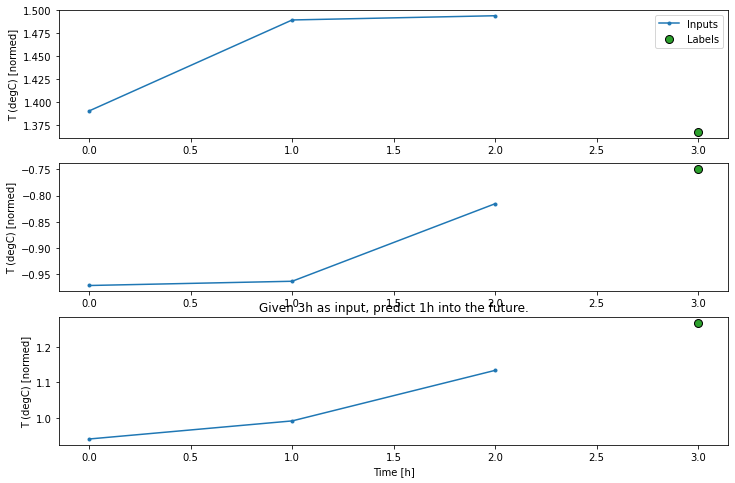

In [48]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 20s - loss: 0.0075 - mean_absolute_error: 0.0683

 26/438 [>.............................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0604 

 51/438 [==>...........................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0598

 75/438 [====>.........................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0600

100/438 [=====>........................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0613

124/438 [=======>......................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0612

148/438 [=========>....................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0608

171/438 [==========>...................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0608

194/438 [============>.................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0610

219/438 [==============>...............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0611

243/438 [===============>..............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0613

267/438 [=================>............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0613

292/438 [===================>..........] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0613

316/438 [====================>.........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0613

340/438 [======================>.......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0613

364/438 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0613

388/438 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0612

412/438 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0613

434/438 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0614

438/438 [==============================] - 1s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0614


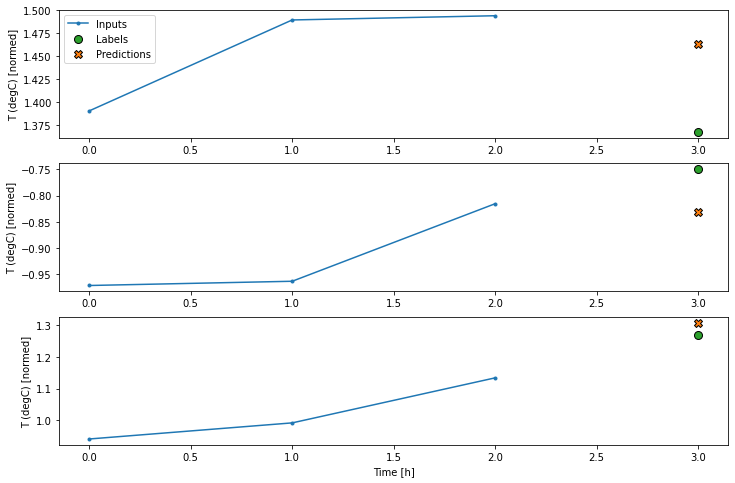

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 57 but received input with shape (32, 456)


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 22s - loss: 0.0045 - mean_absolute_error: 0.0546

 19/438 [>.............................] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0579 

 37/438 [=>............................] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0558

 55/438 [==>...........................] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0574

 73/438 [====>.........................] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0570

 90/438 [=====>........................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0568

108/438 [======>.......................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0561

126/438 [=======>......................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0562

144/438 [========>.....................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

163/438 [==========>...................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0562

182/438 [===========>..................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0559

200/438 [============>.................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0559

218/438 [=============>................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0559

237/438 [===============>..............] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

255/438 [================>.............] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0560

274/438 [=================>............] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0562

292/438 [===================>..........] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

310/438 [====================>.........] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0560

328/438 [=====================>........] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0562

346/438 [======================>.......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0559

364/438 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0559

382/438 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0558

400/438 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0559

418/438 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0561

434/438 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0559

438/438 [==============================] - 1s 3ms/step - loss: 0.0065 - mean_absolute_error: 0.0560


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

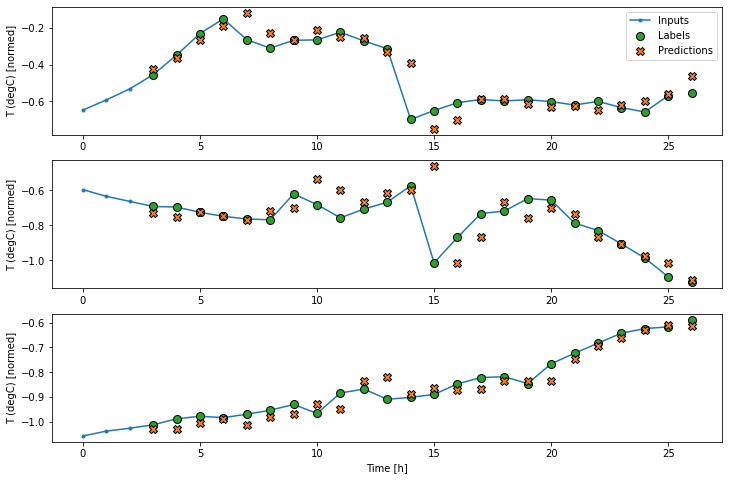

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](images/lstm_1_window.png)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 22s - loss: 0.0058 - mean_absolute_error: 0.0534

 17/438 [>.............................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0530 

 33/438 [=>............................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0527

 49/438 [==>...........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0526

 65/438 [===>..........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0528

 82/438 [====>.........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0526

 98/438 [=====>........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0524

114/438 [======>.......................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0524

130/438 [=======>......................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

146/438 [=========>....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0524

163/438 [==========>...................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0525

180/438 [===========>..................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0524

196/438 [============>.................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

213/438 [=============>................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0525

230/438 [==============>...............] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

246/438 [===============>..............] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

263/438 [=================>............] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

280/438 [==================>...........] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

296/438 [===================>..........] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

312/438 [====================>.........] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

329/438 [=====================>........] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

346/438 [======================>.......] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

362/438 [=======================>......] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

378/438 [========================>.....] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

394/438 [=========================>....] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

411/438 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

427/438 [============================>.] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0525

438/438 [==============================] - 1s 3ms/step - loss: 0.0057 - mean_absolute_error: 0.0525


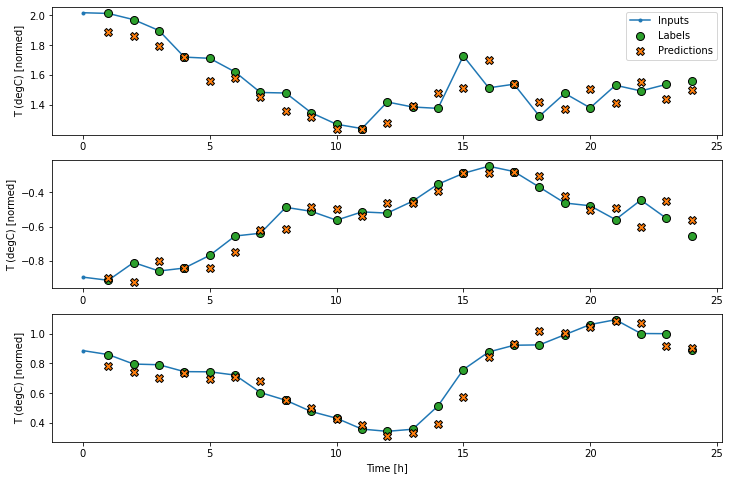

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it.

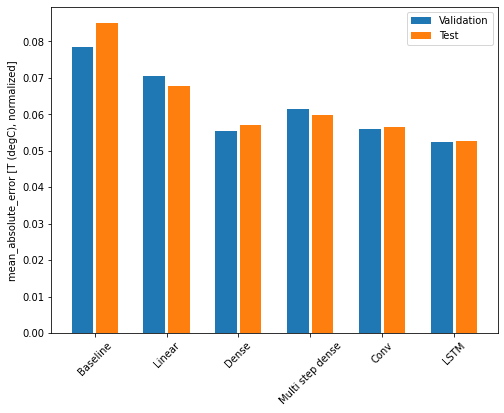

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0678
Dense       : 0.0572
Multi step dense: 0.0597
Conv        : 0.0565
LSTM        : 0.0528


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 39s - loss: 0.0876 - mean_absolute_error: 0.1601

 25/438 [>.............................] - ETA: 0s - loss: 0.0928 - mean_absolute_error: 0.1629 

 49/438 [==>...........................] - ETA: 0s - loss: 0.0915 - mean_absolute_error: 0.1616

 74/438 [====>.........................] - ETA: 0s - loss: 0.0909 - mean_absolute_error: 0.1611

 99/438 [=====>........................] - ETA: 0s - loss: 0.0905 - mean_absolute_error: 0.1608

124/438 [=======>......................] - ETA: 0s - loss: 0.0904 - mean_absolute_error: 0.1606

149/438 [=========>....................] - ETA: 0s - loss: 0.0902 - mean_absolute_error: 0.1605

175/438 [==========>...................] - ETA: 0s - loss: 0.0901 - mean_absolute_error: 0.1603

200/438 [============>.................] - ETA: 0s - loss: 0.0900 - mean_absolute_error: 0.1602

226/438 [==============>...............] - ETA: 0s - loss: 0.0899 - mean_absolute_error: 0.1602

251/438 [================>.............] - ETA: 0s - loss: 0.0898 - mean_absolute_error: 0.1601

275/438 [=================>............] - ETA: 0s - loss: 0.0897 - mean_absolute_error: 0.1600

299/438 [===================>..........] - ETA: 0s - loss: 0.0896 - mean_absolute_error: 0.1599

323/438 [=====================>........] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.1598

347/438 [======================>.......] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.1597

372/438 [========================>.....] - ETA: 0s - loss: 0.0894 - mean_absolute_error: 0.1597

396/438 [==========================>...] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.1596

420/438 [===========================>..] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.1596

438/438 [==============================] - 1s 2ms/step - loss: 0.0893 - mean_absolute_error: 0.1595


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 21s - loss: 0.0495 - mean_absolute_error: 0.1130

 20/439 [>.............................] - ETA: 1s - loss: 0.0644 - mean_absolute_error: 0.1304 

 39/439 [=>............................] - ETA: 1s - loss: 0.0677 - mean_absolute_error: 0.1331

 58/439 [==>...........................] - ETA: 1s - loss: 0.0698 - mean_absolute_error: 0.1348

 77/439 [====>.........................] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1331

 96/439 [=====>........................] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1326

115/439 [======>.......................] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.1328

134/439 [========>.....................] - ETA: 0s - loss: 0.0684 - mean_absolute_error: 0.1326

153/439 [=========>....................] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1329

171/439 [==========>...................] - ETA: 0s - loss: 0.0672 - mean_absolute_error: 0.1321

190/439 [===========>..................] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1327

209/439 [=============>................] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1329

228/439 [==============>...............] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1331

247/439 [===============>..............] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1330

265/439 [=================>............] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1327

282/439 [==================>...........] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1329

300/439 [===================>..........] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1328

319/439 [====================>.........] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1327

338/439 [======================>.......] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1327

356/439 [=======================>......] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1324

374/439 [========================>.....] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1326

392/439 [=========================>....] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1325

410/439 [===========================>..] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.1322

429/439 [============================>.] - ETA: 0s - loss: 0.0675 - mean_absolute_error: 0.1319

439/439 [==============================] - 1s 3ms/step - loss: 0.0675 - mean_absolute_error: 0.1320


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 24s - loss: 0.0638 - mean_absolute_error: 0.1206

 16/438 [>.............................] - ETA: 1s - loss: 0.0623 - mean_absolute_error: 0.1201 

 31/438 [=>............................] - ETA: 1s - loss: 0.0632 - mean_absolute_error: 0.1211

 47/438 [==>...........................] - ETA: 1s - loss: 0.0630 - mean_absolute_error: 0.1211

 63/438 [===>..........................] - ETA: 1s - loss: 0.0620 - mean_absolute_error: 0.1204

 80/438 [====>.........................] - ETA: 1s - loss: 0.0617 - mean_absolute_error: 0.1201

 97/438 [=====>........................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1196

113/438 [======>.......................] - ETA: 1s - loss: 0.0610 - mean_absolute_error: 0.1194

129/438 [=======>......................] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.1194

146/438 [=========>....................] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.1194

162/438 [==========>...................] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1195

179/438 [===========>..................] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1194

196/438 [============>.................] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1193

212/438 [=============>................] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1195

229/438 [==============>...............] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1197

246/438 [===============>..............] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1197

263/438 [=================>............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1199

280/438 [==================>...........] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1199

296/438 [===================>..........] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1198

313/438 [====================>.........] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1199

330/438 [=====================>........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1200

347/438 [======================>.......] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1199

364/438 [=======================>......] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1199

381/438 [=========================>....] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1199

398/438 [==========================>...] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1199

415/438 [===========================>..] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1199

430/438 [============================>.] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1200

438/438 [==============================] - 1s 3ms/step - loss: 0.0616 - mean_absolute_error: 0.1200



CPU times: user 4min 4s, sys: 1min, total: 5min 5s
Wall time: 1min 54s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 21s - loss: 0.0658 - mean_absolute_error: 0.1203

 17/438 [>.............................] - ETA: 1s - loss: 0.0637 - mean_absolute_error: 0.1189 

 33/438 [=>............................] - ETA: 1s - loss: 0.0633 - mean_absolute_error: 0.1189

 49/438 [==>...........................] - ETA: 1s - loss: 0.0635 - mean_absolute_error: 0.1190

 66/438 [===>..........................] - ETA: 1s - loss: 0.0630 - mean_absolute_error: 0.1185

 83/438 [====>.........................] - ETA: 1s - loss: 0.0635 - mean_absolute_error: 0.1190

100/438 [=====>........................] - ETA: 1s - loss: 0.0635 - mean_absolute_error: 0.1189

117/438 [=======>......................] - ETA: 1s - loss: 0.0634 - mean_absolute_error: 0.1189

131/438 [=======>......................] - ETA: 0s - loss: 0.0634 - mean_absolute_error: 0.1190

147/438 [=========>....................] - ETA: 0s - loss: 0.0632 - mean_absolute_error: 0.1188

163/438 [==========>...................] - ETA: 0s - loss: 0.0631 - mean_absolute_error: 0.1189

179/438 [===========>..................] - ETA: 0s - loss: 0.0632 - mean_absolute_error: 0.1190

196/438 [============>.................] - ETA: 0s - loss: 0.0632 - mean_absolute_error: 0.1189

213/438 [=============>................] - ETA: 0s - loss: 0.0629 - mean_absolute_error: 0.1187

230/438 [==============>...............] - ETA: 0s - loss: 0.0629 - mean_absolute_error: 0.1186

247/438 [===============>..............] - ETA: 0s - loss: 0.0628 - mean_absolute_error: 0.1186

264/438 [=================>............] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.1184

281/438 [==================>...........] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1182

297/438 [===================>..........] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1182

313/438 [====================>.........] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1182

329/438 [=====================>........] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1181

345/438 [======================>.......] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1182

361/438 [=======================>......] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1181

378/438 [========================>.....] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1181

394/438 [=========================>....] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1181

410/438 [===========================>..] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

427/438 [============================>.] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1181

438/438 [==============================] - 1s 3ms/step - loss: 0.0623 - mean_absolute_error: 0.1181



CPU times: user 2min 15s, sys: 34.3 s, total: 2min 49s
Wall time: 1min 3s


#### Performance

Here is the overall performance for these multi-output models.

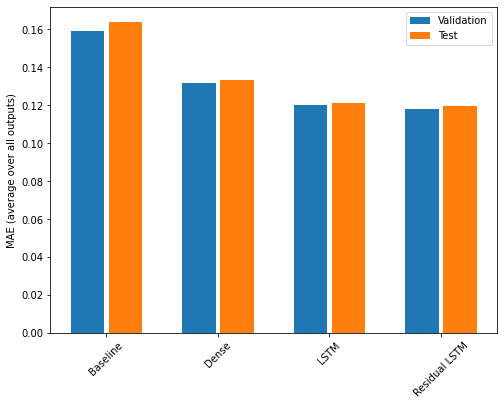

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1331
LSTM           : 0.1212
Residual LSTM  : 0.1194


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

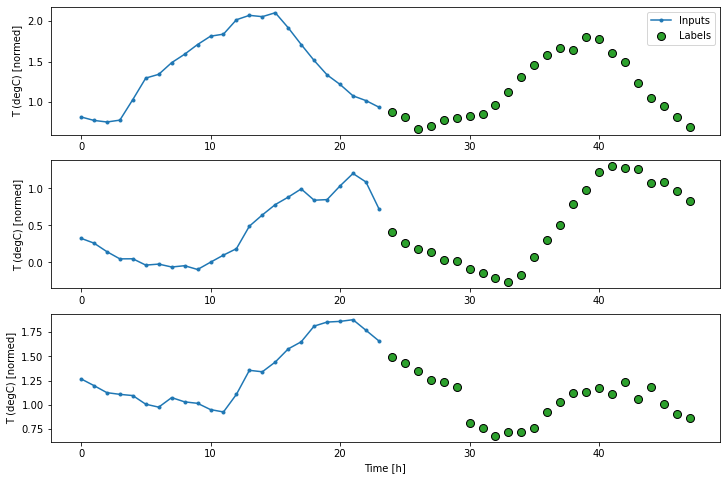

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 53s - loss: 0.6202 - mean_absolute_error: 0.4957

 25/437 [>.............................] - ETA: 0s - loss: 0.6128 - mean_absolute_error: 0.4964 

 49/437 [==>...........................] - ETA: 0s - loss: 0.6153 - mean_absolute_error: 0.4963

 74/437 [====>.........................] - ETA: 0s - loss: 0.6176 - mean_absolute_error: 0.4972

 98/437 [=====>........................] - ETA: 0s - loss: 0.6196 - mean_absolute_error: 0.4979

122/437 [=======>......................] - ETA: 0s - loss: 0.6209 - mean_absolute_error: 0.4984

146/437 [=========>....................] - ETA: 0s - loss: 0.6219 - mean_absolute_error: 0.4988

170/437 [==========>...................] - ETA: 0s - loss: 0.6227 - mean_absolute_error: 0.4991

194/437 [============>.................] - ETA: 0s - loss: 0.6235 - mean_absolute_error: 0.4993

218/437 [=============>................] - ETA: 0s - loss: 0.6240 - mean_absolute_error: 0.4994

242/437 [===============>..............] - ETA: 0s - loss: 0.6244 - mean_absolute_error: 0.4995

266/437 [=================>............] - ETA: 0s - loss: 0.6248 - mean_absolute_error: 0.4996

290/437 [==================>...........] - ETA: 0s - loss: 0.6251 - mean_absolute_error: 0.4997

314/437 [====================>.........] - ETA: 0s - loss: 0.6253 - mean_absolute_error: 0.4998

338/437 [======================>.......] - ETA: 0s - loss: 0.6253 - mean_absolute_error: 0.4998

361/437 [=======================>......] - ETA: 0s - loss: 0.6254 - mean_absolute_error: 0.4998

384/437 [=========================>....] - ETA: 0s - loss: 0.6254 - mean_absolute_error: 0.4999

407/437 [==========================>...] - ETA: 0s - loss: 0.6255 - mean_absolute_error: 0.4999

429/437 [============================>.] - ETA: 0s - loss: 0.6255 - mean_absolute_error: 0.4999

437/437 [==============================] - 1s 2ms/step - loss: 0.6256 - mean_absolute_error: 0.4999


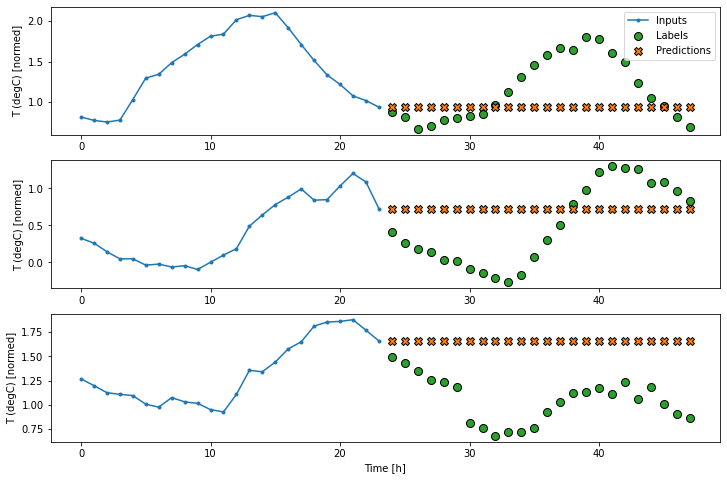

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 46s - loss: 0.4322 - mean_absolute_error: 0.4108

 25/437 [>.............................] - ETA: 0s - loss: 0.4154 - mean_absolute_error: 0.3943 

 50/437 [==>...........................] - ETA: 0s - loss: 0.4223 - mean_absolute_error: 0.3957

 75/437 [====>.........................] - ETA: 0s - loss: 0.4248 - mean_absolute_error: 0.3960

 99/437 [=====>........................] - ETA: 0s - loss: 0.4260 - mean_absolute_error: 0.3962

123/437 [=======>......................] - ETA: 0s - loss: 0.4265 - mean_absolute_error: 0.3963

148/437 [=========>....................] - ETA: 0s - loss: 0.4271 - mean_absolute_error: 0.3964

172/437 [==========>...................] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.3964

196/437 [============>.................] - ETA: 0s - loss: 0.4277 - mean_absolute_error: 0.3964

220/437 [==============>...............] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.3964

245/437 [===============>..............] - ETA: 0s - loss: 0.4277 - mean_absolute_error: 0.3963

269/437 [=================>............] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.3963

292/437 [===================>..........] - ETA: 0s - loss: 0.4279 - mean_absolute_error: 0.3963

316/437 [====================>.........] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.3963

340/437 [======================>.......] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.3963

364/437 [=======================>......] - ETA: 0s - loss: 0.4281 - mean_absolute_error: 0.3963

389/437 [=========================>....] - ETA: 0s - loss: 0.4281 - mean_absolute_error: 0.3963

414/437 [===========================>..] - ETA: 0s - loss: 0.4281 - mean_absolute_error: 0.3963

437/437 [==============================] - 1s 2ms/step - loss: 0.4280 - mean_absolute_error: 0.3963


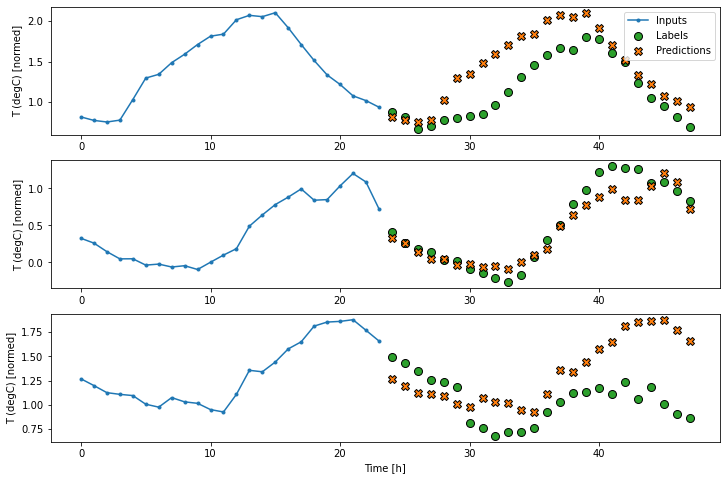

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 21s - loss: 0.2057 - mean_absolute_error: 0.2696

 23/437 [>.............................] - ETA: 0s - loss: 0.2436 - mean_absolute_error: 0.2993 

 45/437 [==>...........................] - ETA: 0s - loss: 0.2431 - mean_absolute_error: 0.2997

 68/437 [===>..........................] - ETA: 0s - loss: 0.2506 - mean_absolute_error: 0.3033

 89/437 [=====>........................] - ETA: 0s - loss: 0.2556 - mean_absolute_error: 0.3060

109/437 [======>.......................] - ETA: 0s - loss: 0.2568 - mean_absolute_error: 0.3065

130/437 [=======>......................] - ETA: 0s - loss: 0.2573 - mean_absolute_error: 0.3070

152/437 [=========>....................] - ETA: 0s - loss: 0.2558 - mean_absolute_error: 0.3058

174/437 [==========>...................] - ETA: 0s - loss: 0.2544 - mean_absolute_error: 0.3047

196/437 [============>.................] - ETA: 0s - loss: 0.2544 - mean_absolute_error: 0.3047

217/437 [=============>................] - ETA: 0s - loss: 0.2557 - mean_absolute_error: 0.3054

239/437 [===============>..............] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.3054

261/437 [================>.............] - ETA: 0s - loss: 0.2553 - mean_absolute_error: 0.3050

282/437 [==================>...........] - ETA: 0s - loss: 0.2557 - mean_absolute_error: 0.3052

303/437 [===================>..........] - ETA: 0s - loss: 0.2560 - mean_absolute_error: 0.3055

325/437 [=====================>........] - ETA: 0s - loss: 0.2561 - mean_absolute_error: 0.3054

347/437 [======================>.......] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3054

369/437 [========================>.....] - ETA: 0s - loss: 0.2558 - mean_absolute_error: 0.3051

391/437 [=========================>....] - ETA: 0s - loss: 0.2558 - mean_absolute_error: 0.3052

413/437 [===========================>..] - ETA: 0s - loss: 0.2560 - mean_absolute_error: 0.3052

433/437 [============================>.] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.3052

437/437 [==============================] - 1s 2ms/step - loss: 0.2561 - mean_absolute_error: 0.3052


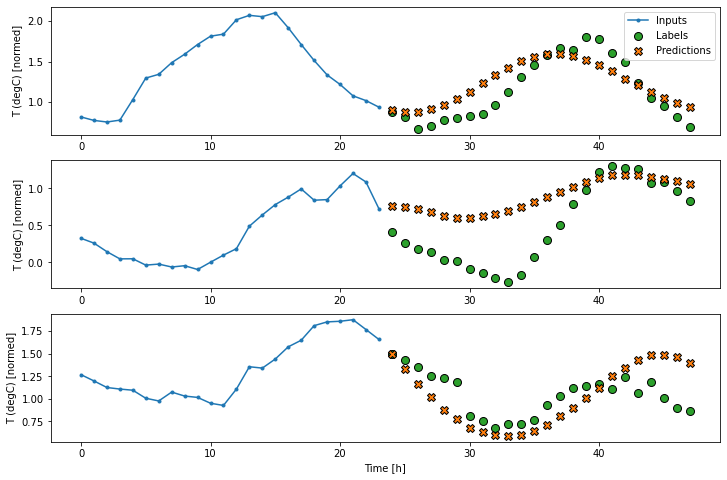

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

  1/437 [..............................] - ETA: 20s - loss: 0.2182 - mean_absolute_error: 0.2725

 20/437 [>.............................] - ETA: 1s - loss: 0.2224 - mean_absolute_error: 0.2848 

 39/437 [=>............................] - ETA: 1s - loss: 0.2257 - mean_absolute_error: 0.2852

 57/437 [==>...........................] - ETA: 1s - loss: 0.2236 - mean_absolute_error: 0.2841

 76/437 [====>.........................] - ETA: 0s - loss: 0.2210 - mean_absolute_error: 0.2826

 95/437 [=====>........................] - ETA: 0s - loss: 0.2196 - mean_absolute_error: 0.2811

113/437 [======>.......................] - ETA: 0s - loss: 0.2208 - mean_absolute_error: 0.2817

132/437 [========>.....................] - ETA: 0s - loss: 0.2204 - mean_absolute_error: 0.2817

151/437 [=========>....................] - ETA: 0s - loss: 0.2196 - mean_absolute_error: 0.2816

169/437 [==========>...................] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2808

188/437 [===========>..................] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2810

207/437 [=============>................] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2809

225/437 [==============>...............] - ETA: 0s - loss: 0.2180 - mean_absolute_error: 0.2807

243/437 [===============>..............] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2809

261/437 [================>.............] - ETA: 0s - loss: 0.2188 - mean_absolute_error: 0.2811

280/437 [==================>...........] - ETA: 0s - loss: 0.2187 - mean_absolute_error: 0.2810

298/437 [===================>..........] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2810

317/437 [====================>.........] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2808

336/437 [======================>.......] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2807

355/437 [=======================>......] - ETA: 0s - loss: 0.2182 - mean_absolute_error: 0.2804

374/437 [========================>.....] - ETA: 0s - loss: 0.2180 - mean_absolute_error: 0.2802

392/437 [=========================>....] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2806

411/437 [===========================>..] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2805

430/437 [============================>.] - ETA: 0s - loss: 0.2187 - mean_absolute_error: 0.2807

437/437 [==============================] - 1s 3ms/step - loss: 0.2185 - mean_absolute_error: 0.2805


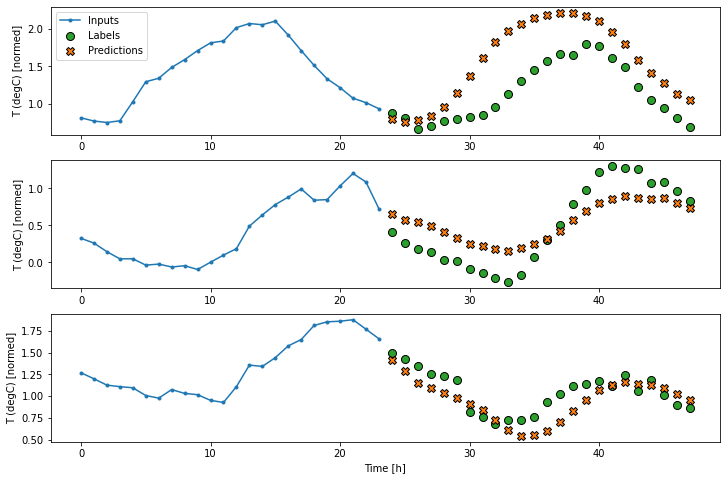

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 22s - loss: 0.2598 - mean_absolute_error: 0.3045

 20/437 [>.............................] - ETA: 1s - loss: 0.2252 - mean_absolute_error: 0.2857 

 39/437 [=>............................] - ETA: 1s - loss: 0.2171 - mean_absolute_error: 0.2818

 58/437 [==>...........................] - ETA: 1s - loss: 0.2119 - mean_absolute_error: 0.2799

 77/437 [====>.........................] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2819

 97/437 [=====>........................] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2821

117/437 [=======>......................] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2823

137/437 [========>.....................] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2824

156/437 [=========>....................] - ETA: 0s - loss: 0.2174 - mean_absolute_error: 0.2831

175/437 [===========>..................] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2820

194/437 [============>.................] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2813

214/437 [=============>................] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2814

233/437 [==============>...............] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2816

253/437 [================>.............] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2814

273/437 [=================>............] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2820

293/437 [===================>..........] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2818

312/437 [====================>.........] - ETA: 0s - loss: 0.2153 - mean_absolute_error: 0.2820

331/437 [=====================>........] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2822

350/437 [=======================>......] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2824

368/437 [========================>.....] - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.2823

386/437 [=========================>....] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2824

404/437 [==========================>...] - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.2824

422/437 [===========================>..] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2823

437/437 [==============================] - 1s 3ms/step - loss: 0.2163 - mean_absolute_error: 0.2825


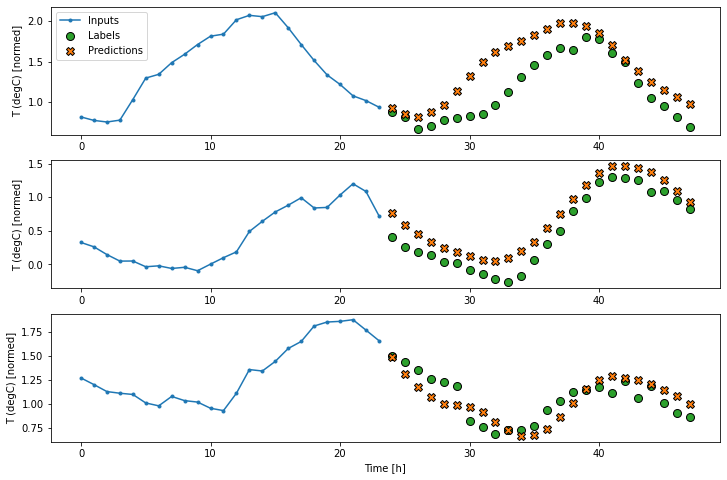

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 19s - loss: 0.2192 - mean_absolute_error: 0.2812

 20/437 [>.............................] - ETA: 1s - loss: 0.2070 - mean_absolute_error: 0.2791 

 39/437 [=>............................] - ETA: 1s - loss: 0.2070 - mean_absolute_error: 0.2782

 58/437 [==>...........................] - ETA: 1s - loss: 0.2062 - mean_absolute_error: 0.2788

 77/437 [====>.........................] - ETA: 0s - loss: 0.2105 - mean_absolute_error: 0.2811

 96/437 [=====>........................] - ETA: 0s - loss: 0.2126 - mean_absolute_error: 0.2824

115/437 [======>.......................] - ETA: 0s - loss: 0.2119 - mean_absolute_error: 0.2823

134/437 [========>.....................] - ETA: 0s - loss: 0.2122 - mean_absolute_error: 0.2823

153/437 [=========>....................] - ETA: 0s - loss: 0.2120 - mean_absolute_error: 0.2821

172/437 [==========>...................] - ETA: 0s - loss: 0.2112 - mean_absolute_error: 0.2819

191/437 [============>.................] - ETA: 0s - loss: 0.2112 - mean_absolute_error: 0.2817

210/437 [=============>................] - ETA: 0s - loss: 0.2118 - mean_absolute_error: 0.2819

229/437 [==============>...............] - ETA: 0s - loss: 0.2116 - mean_absolute_error: 0.2818

248/437 [================>.............] - ETA: 0s - loss: 0.2117 - mean_absolute_error: 0.2821

267/437 [=================>............] - ETA: 0s - loss: 0.2120 - mean_absolute_error: 0.2824

286/437 [==================>...........] - ETA: 0s - loss: 0.2123 - mean_absolute_error: 0.2826

305/437 [===================>..........] - ETA: 0s - loss: 0.2127 - mean_absolute_error: 0.2829

324/437 [=====================>........] - ETA: 0s - loss: 0.2125 - mean_absolute_error: 0.2828

342/437 [======================>.......] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2831

361/437 [=======================>......] - ETA: 0s - loss: 0.2124 - mean_absolute_error: 0.2827

380/437 [=========================>....] - ETA: 0s - loss: 0.2122 - mean_absolute_error: 0.2826

399/437 [==========================>...] - ETA: 0s - loss: 0.2125 - mean_absolute_error: 0.2828

418/437 [===========================>..] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2831

437/437 [==============================] - 1s 3ms/step - loss: 0.2127 - mean_absolute_error: 0.2830


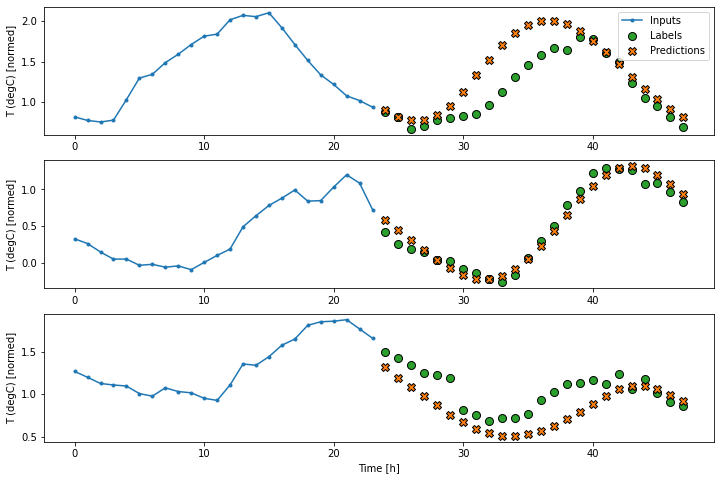

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)


#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step `LSTM` models: An `LSTM` followed by a `layers.Dense` that converts the `LSTM` outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach to collecting the output predictions is to use a python list, and `tf.stack` after the loop.

Note: Stacking a python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length you would need to use a `tf.TensorArray` instead of a python list, and `tf.range` instead of the python `range`.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now train the model:

  1/437 [..............................] - ETA: 21s - loss: 0.1975 - mean_absolute_error: 0.2912

  9/437 [..............................] - ETA: 2s - loss: 0.2176 - mean_absolute_error: 0.2923 

 17/437 [>.............................] - ETA: 2s - loss: 0.2219 - mean_absolute_error: 0.2979

 25/437 [>.............................] - ETA: 2s - loss: 0.2189 - mean_absolute_error: 0.2947

 33/437 [=>............................] - ETA: 2s - loss: 0.2166 - mean_absolute_error: 0.2947

 41/437 [=>............................] - ETA: 2s - loss: 0.2195 - mean_absolute_error: 0.2970

 49/437 [==>...........................] - ETA: 2s - loss: 0.2164 - mean_absolute_error: 0.2951

 57/437 [==>...........................] - ETA: 2s - loss: 0.2166 - mean_absolute_error: 0.2949

 65/437 [===>..........................] - ETA: 2s - loss: 0.2185 - mean_absolute_error: 0.2958

 73/437 [====>.........................] - ETA: 2s - loss: 0.2182 - mean_absolute_error: 0.2958

 81/437 [====>.........................] - ETA: 2s - loss: 0.2195 - mean_absolute_error: 0.2966

 89/437 [=====>........................] - ETA: 2s - loss: 0.2197 - mean_absolute_error: 0.2967

 97/437 [=====>........................] - ETA: 2s - loss: 0.2194 - mean_absolute_error: 0.2963

105/437 [======>.......................] - ETA: 2s - loss: 0.2193 - mean_absolute_error: 0.2960

113/437 [======>.......................] - ETA: 2s - loss: 0.2195 - mean_absolute_error: 0.2960

121/437 [=======>......................] - ETA: 2s - loss: 0.2192 - mean_absolute_error: 0.2960

129/437 [=======>......................] - ETA: 2s - loss: 0.2199 - mean_absolute_error: 0.2967

137/437 [========>.....................] - ETA: 2s - loss: 0.2198 - mean_absolute_error: 0.2965

145/437 [========>.....................] - ETA: 1s - loss: 0.2200 - mean_absolute_error: 0.2966

153/437 [=========>....................] - ETA: 1s - loss: 0.2196 - mean_absolute_error: 0.2962

161/437 [==========>...................] - ETA: 1s - loss: 0.2189 - mean_absolute_error: 0.2960

169/437 [==========>...................] - ETA: 1s - loss: 0.2195 - mean_absolute_error: 0.2964

177/437 [===========>..................] - ETA: 1s - loss: 0.2201 - mean_absolute_error: 0.2966

185/437 [===========>..................] - ETA: 1s - loss: 0.2206 - mean_absolute_error: 0.2968

193/437 [============>.................] - ETA: 1s - loss: 0.2206 - mean_absolute_error: 0.2968

201/437 [============>.................] - ETA: 1s - loss: 0.2207 - mean_absolute_error: 0.2969

209/437 [=============>................] - ETA: 1s - loss: 0.2212 - mean_absolute_error: 0.2971

217/437 [=============>................] - ETA: 1s - loss: 0.2211 - mean_absolute_error: 0.2970

225/437 [==============>...............] - ETA: 1s - loss: 0.2216 - mean_absolute_error: 0.2973

233/437 [==============>...............] - ETA: 1s - loss: 0.2219 - mean_absolute_error: 0.2973

241/437 [===============>..............] - ETA: 1s - loss: 0.2224 - mean_absolute_error: 0.2976

249/437 [================>.............] - ETA: 1s - loss: 0.2230 - mean_absolute_error: 0.2980

256/437 [================>.............] - ETA: 1s - loss: 0.2230 - mean_absolute_error: 0.2980

264/437 [=================>............] - ETA: 1s - loss: 0.2229 - mean_absolute_error: 0.2978

272/437 [=================>............] - ETA: 1s - loss: 0.2232 - mean_absolute_error: 0.2980

280/437 [==================>...........] - ETA: 1s - loss: 0.2234 - mean_absolute_error: 0.2982

288/437 [==================>...........] - ETA: 1s - loss: 0.2234 - mean_absolute_error: 0.2982

296/437 [===================>..........] - ETA: 0s - loss: 0.2231 - mean_absolute_error: 0.2981

304/437 [===================>..........] - ETA: 0s - loss: 0.2229 - mean_absolute_error: 0.2980

312/437 [====================>.........] - ETA: 0s - loss: 0.2226 - mean_absolute_error: 0.2977

320/437 [====================>.........] - ETA: 0s - loss: 0.2226 - mean_absolute_error: 0.2977

328/437 [=====================>........] - ETA: 0s - loss: 0.2227 - mean_absolute_error: 0.2978

336/437 [======================>.......] - ETA: 0s - loss: 0.2228 - mean_absolute_error: 0.2978

344/437 [======================>.......] - ETA: 0s - loss: 0.2228 - mean_absolute_error: 0.2980

352/437 [=======================>......] - ETA: 0s - loss: 0.2226 - mean_absolute_error: 0.2979

360/437 [=======================>......] - ETA: 0s - loss: 0.2224 - mean_absolute_error: 0.2978

368/437 [========================>.....] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2978

376/437 [========================>.....] - ETA: 0s - loss: 0.2230 - mean_absolute_error: 0.2981

384/437 [=========================>....] - ETA: 0s - loss: 0.2227 - mean_absolute_error: 0.2980

392/437 [=========================>....] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2978

400/437 [==========================>...] - ETA: 0s - loss: 0.2224 - mean_absolute_error: 0.2977

408/437 [===========================>..] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2978

416/437 [===========================>..] - ETA: 0s - loss: 0.2222 - mean_absolute_error: 0.2976

424/437 [============================>.] - ETA: 0s - loss: 0.2223 - mean_absolute_error: 0.2976

431/437 [============================>.] - ETA: 0s - loss: 0.2224 - mean_absolute_error: 0.2976

437/437 [==============================] - 3s 7ms/step - loss: 0.2224 - mean_absolute_error: 0.2976


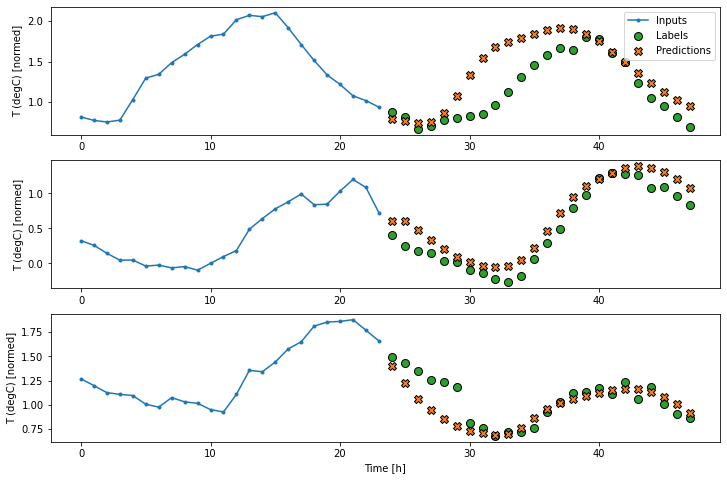

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

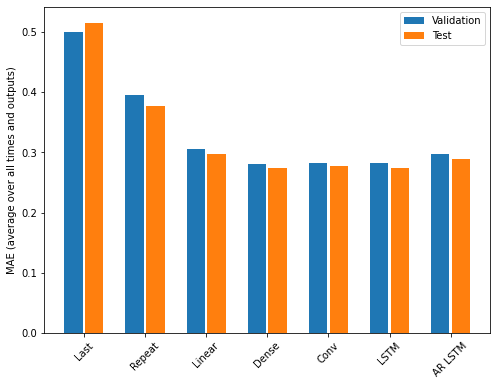

In [91]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2982
Dense   : 0.2741
Conv    : 0.2770
LSTM    : 0.2748
AR LSTM : 0.2892


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

* For further understanding, see:
  * Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition 
  * Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).
  * Lesson 8 of [Udacity's intro to TensorFlow for deep learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187), and the [exercise notebooks](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning) 
* Also remember that you can implement any [classical time series model](https://otexts.com/fpp2/index.html) in TensorFlow, this tutorial just focuses on TensorFlow's built-in functionality.